In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
from sklearn.neural_network import MLPClassifier

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'solver': ['adam'],
    'max_iter': [200, 300]
}


In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize


def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = MLPClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist_mlp,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = MLPClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics




============== Training Phase 1 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1785
           1       0.60      0.28      0.39       604
           2       0.46      0.30      0.36       258
           3       0.32      0.19      0.24        59
           4       0.50      0.11      0.18         9

    accuracy                           0.71      2715
   macro avg       0.53      0.36      0.40      2715
weighted avg       0.68      0.71      0.67      2715



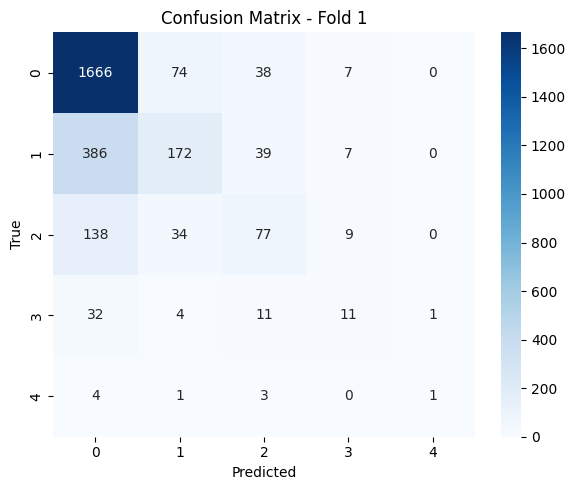

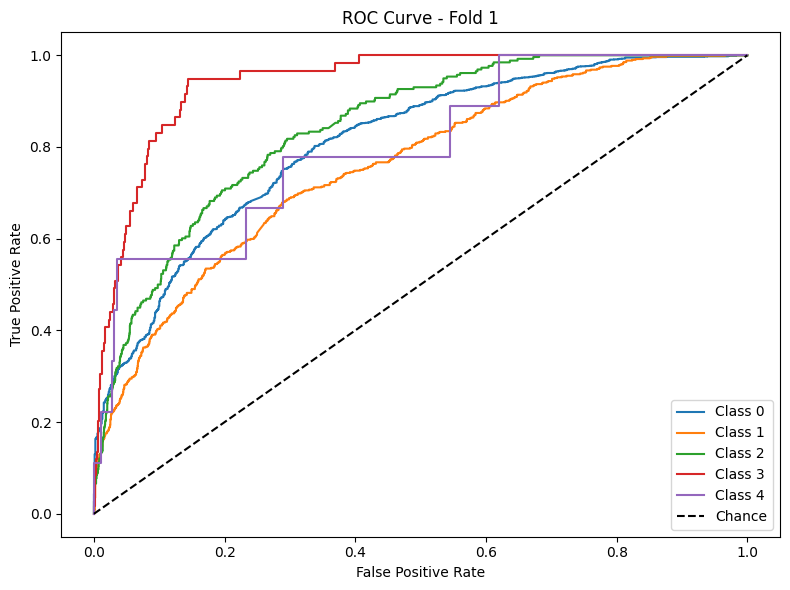


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83      1786
           1       0.57      0.31      0.40       603
           2       0.52      0.33      0.40       258
           3       0.26      0.24      0.25        59
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2714
   macro avg       0.42      0.36      0.38      2714
weighted avg       0.68      0.71      0.68      2714



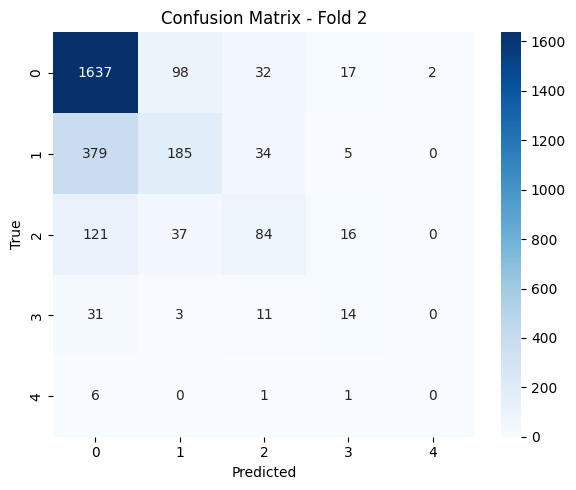

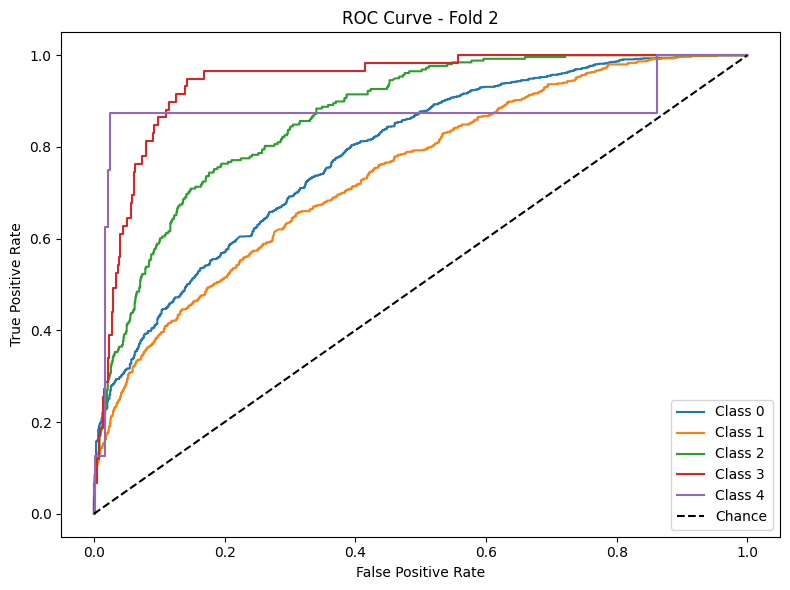


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83      1786
           1       0.58      0.32      0.41       603
           2       0.46      0.26      0.33       258
           3       0.50      0.32      0.39        59
           4       0.33      0.12      0.18         8

    accuracy                           0.71      2714
   macro avg       0.52      0.39      0.43      2714
weighted avg       0.68      0.71      0.68      2714



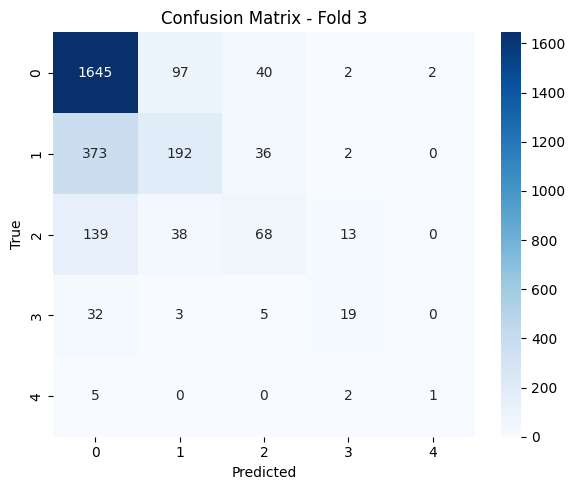

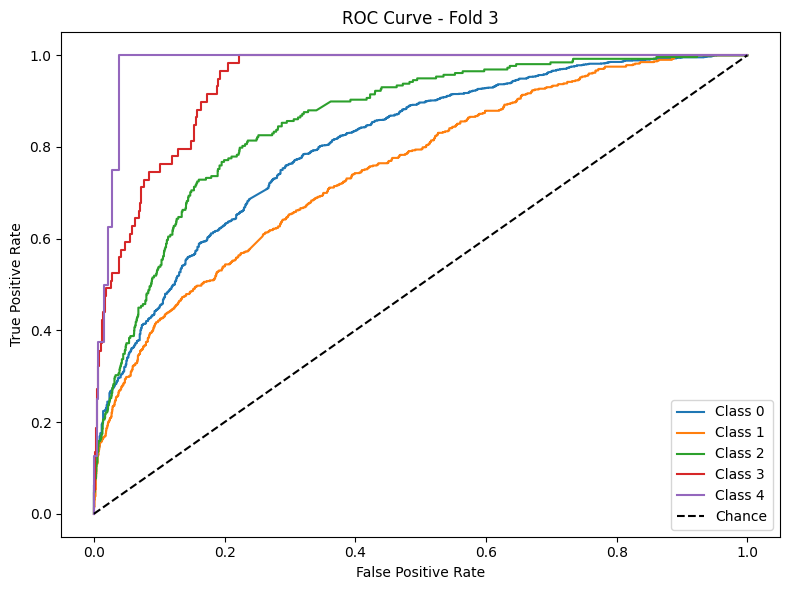

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.83      1785
           1       0.62      0.35      0.45       603
           2       0.59      0.33      0.43       258
           3       0.30      0.15      0.20        59
           4       0.00      0.00      0.00         9

    accuracy                           0.73      2714
   macro avg       0.45      0.35      0.38      2714
weighted avg       0.70      0.73      0.69      2714



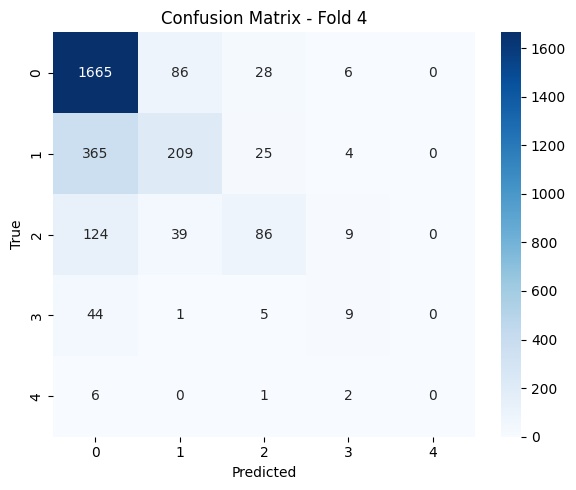

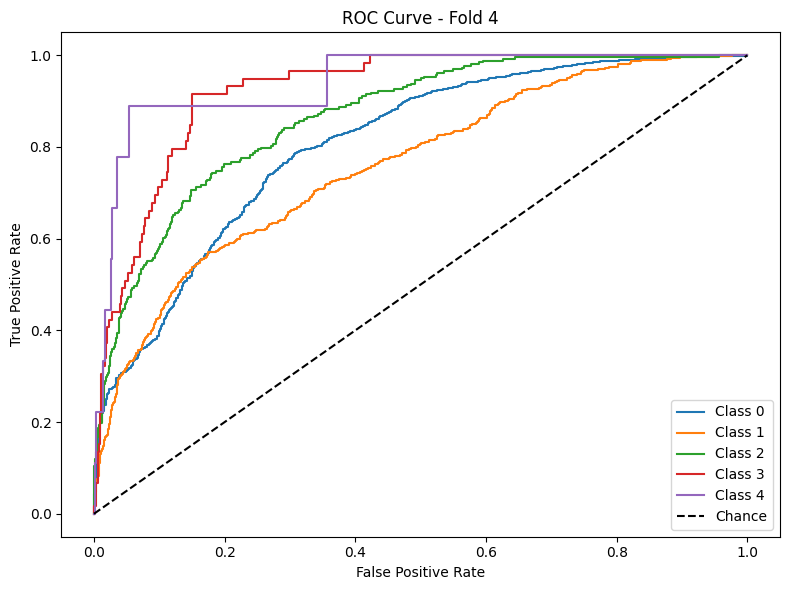


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1785
           1       0.62      0.30      0.40       603
           2       0.47      0.31      0.37       258
           3       0.42      0.14      0.21        59
           4       0.00      0.00      0.00         9

    accuracy                           0.71      2714
   macro avg       0.45      0.34      0.36      2714
weighted avg       0.68      0.71      0.68      2714



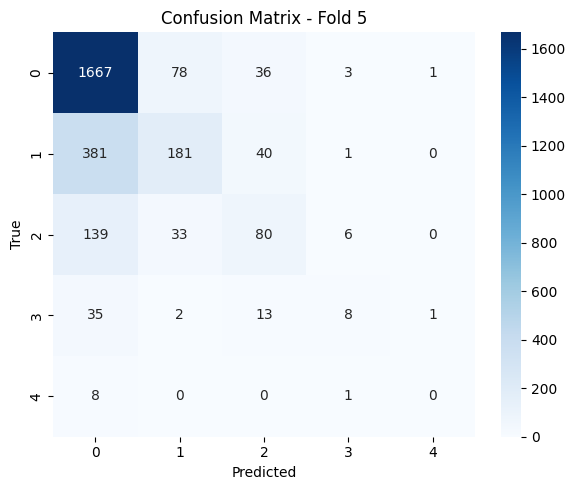

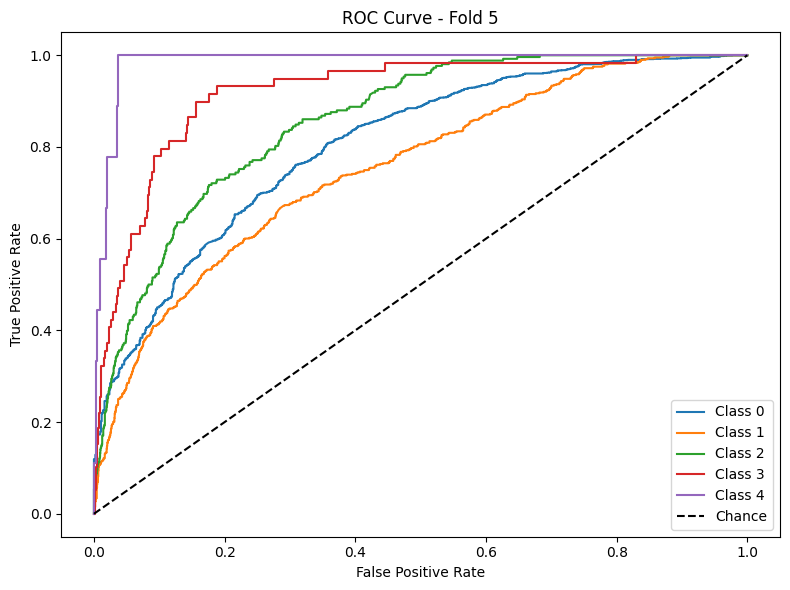


Average Accuracy: 0.7131
Average F1 Macro: 0.3897
Average AUC: 0.8526


============== Training Phase 2 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'logistic'}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and 


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1489
           1       0.58      0.27      0.37       488
           2       0.41      0.33      0.37       220
           3       0.33      0.11      0.17        54
           4       0.00      0.00      0.00         9

    accuracy                           0.70      2260
   macro avg       0.42      0.33      0.35      2260
weighted avg       0.67      0.70      0.67      2260



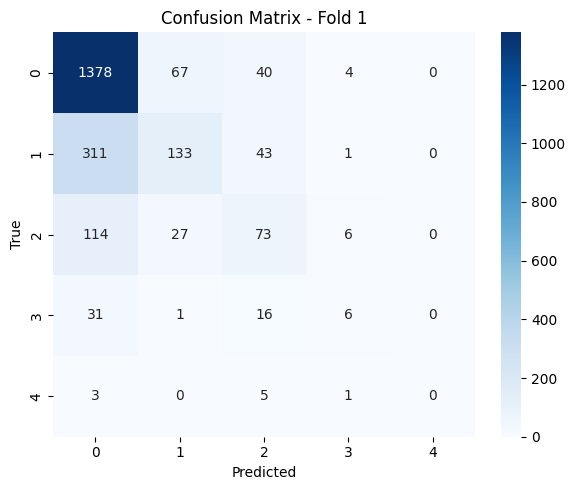

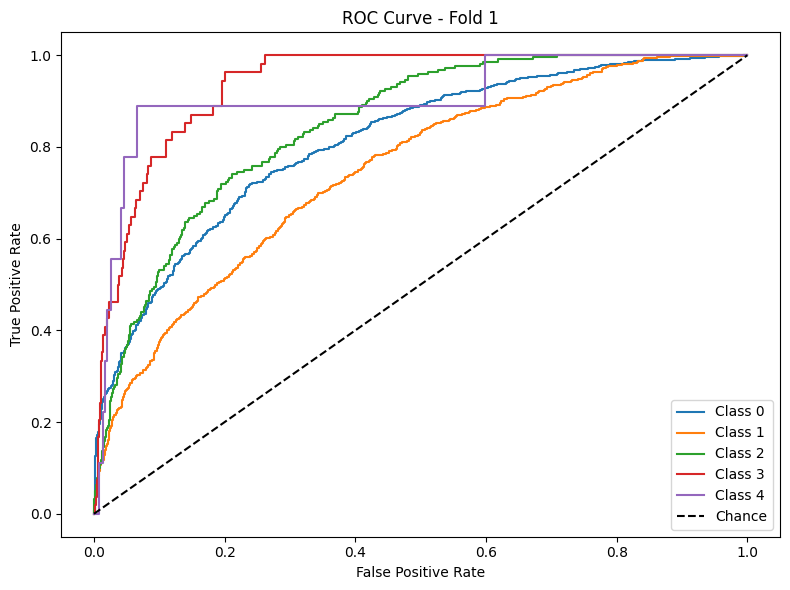

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and 


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.83      1489
           1       0.55      0.28      0.37       489
           2       0.51      0.29      0.37       219
           3       0.26      0.15      0.19        55
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2260
   macro avg       0.41      0.33      0.35      2260
weighted avg       0.66      0.70      0.67      2260



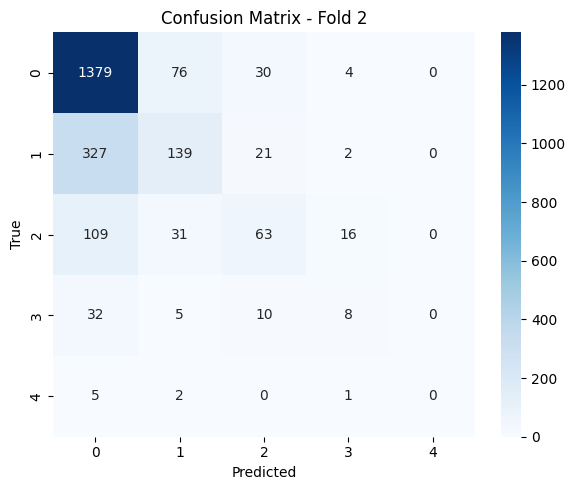

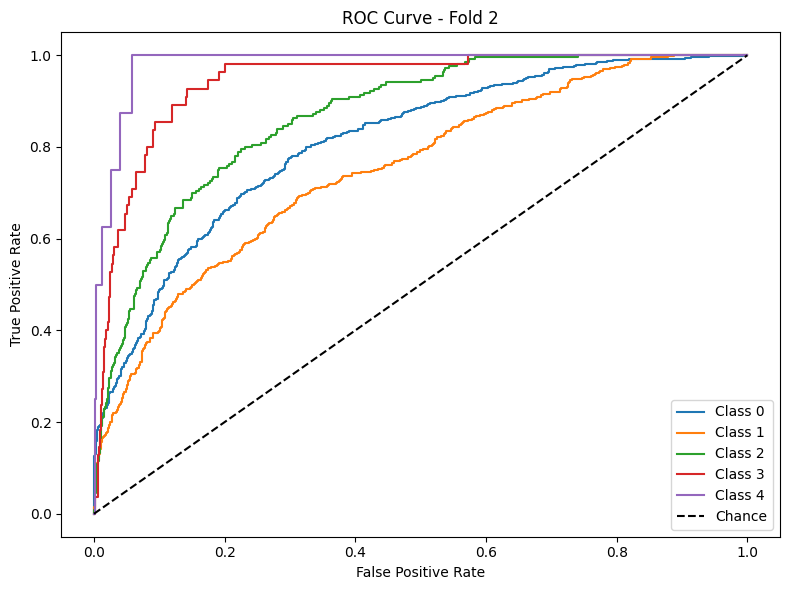

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      1489
           1       0.52      0.20      0.29       489
           2       0.53      0.30      0.38       219
           3       0.39      0.20      0.27        54
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2259
   macro avg       0.44      0.33      0.36      2259
weighted avg       0.66      0.70      0.65      2259



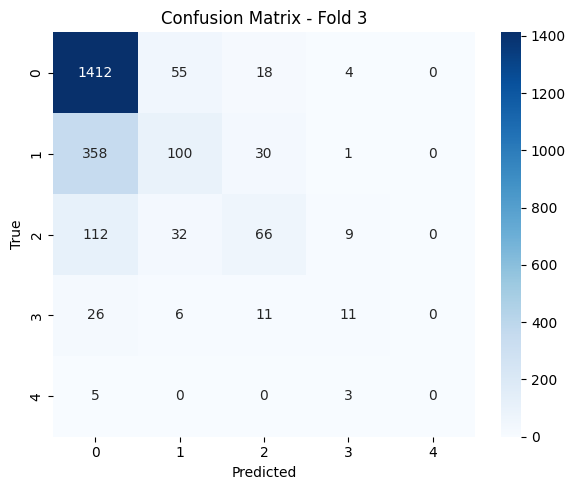

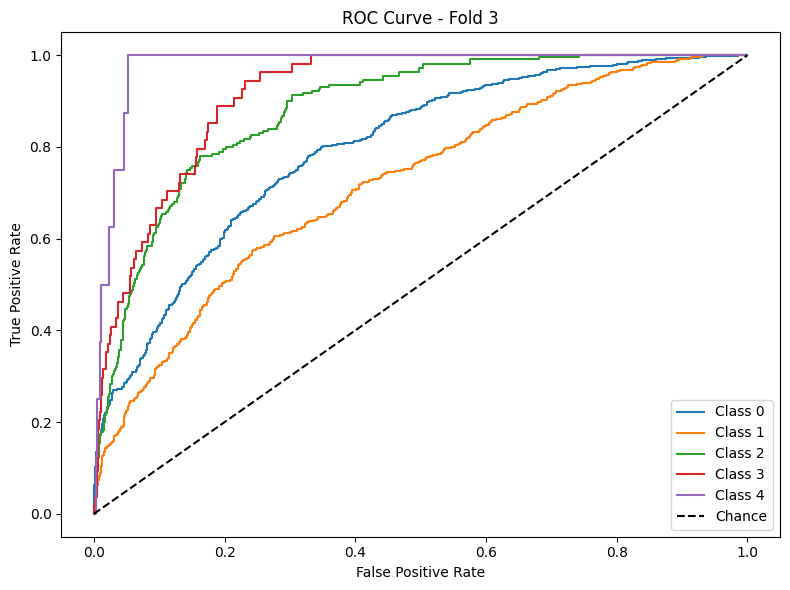

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.82      1489
           1       0.58      0.23      0.33       489
           2       0.46      0.32      0.38       219
           3       0.28      0.09      0.14        54
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2259
   macro avg       0.41      0.32      0.33      2259
weighted avg       0.66      0.70      0.65      2259



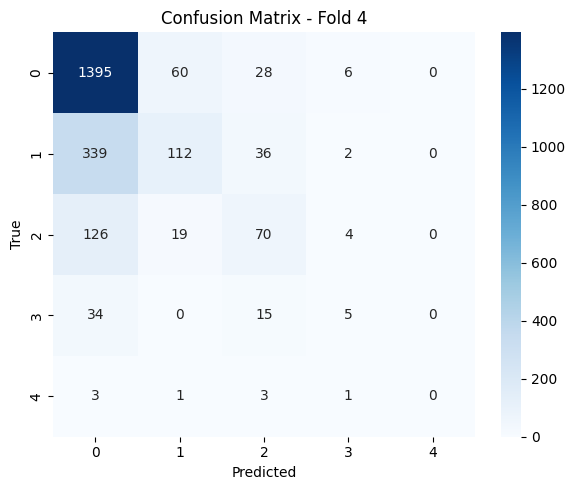

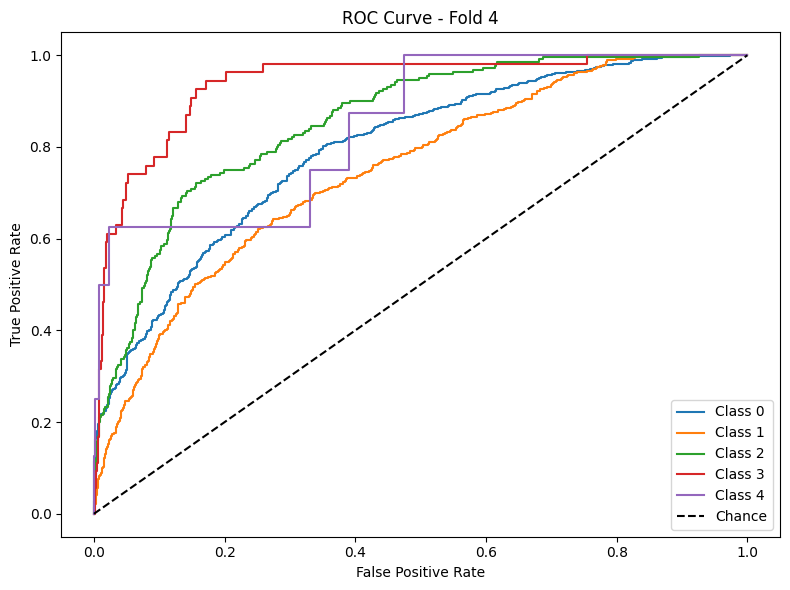


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84      1490
           1       0.60      0.29      0.39       488
           2       0.45      0.37      0.40       219
           3       0.50      0.19      0.27        54
           4       1.00      0.12      0.22         8

    accuracy                           0.72      2259
   macro avg       0.66      0.38      0.43      2259
weighted avg       0.69      0.72      0.68      2259



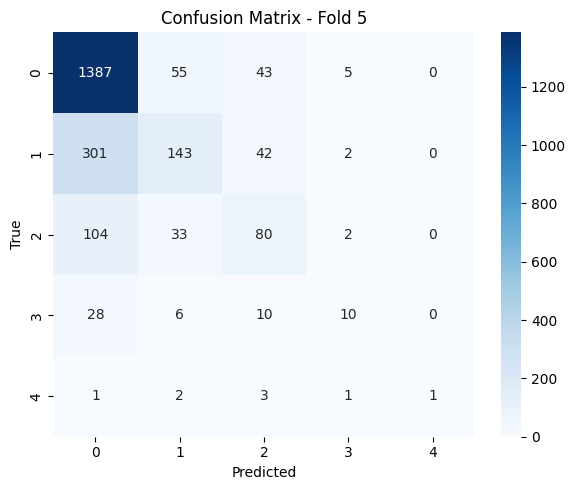

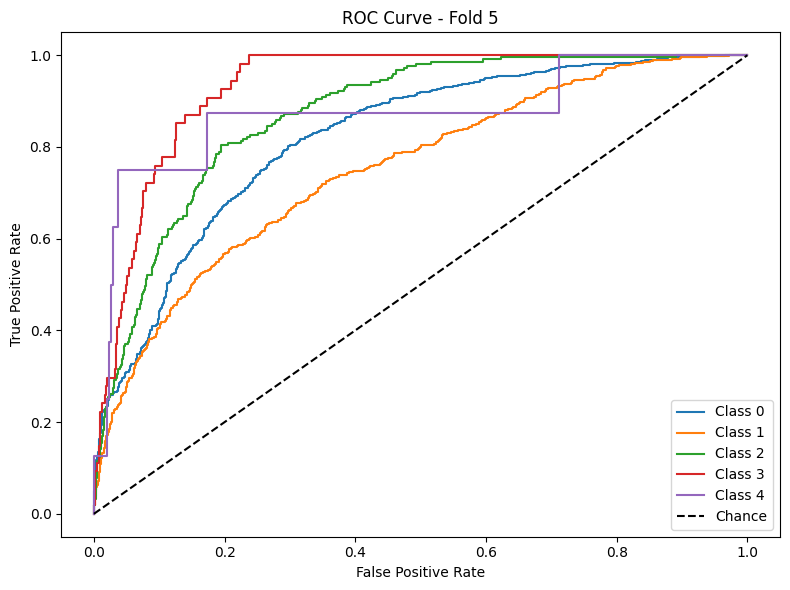


Average Accuracy: 0.7056
Average F1 Macro: 0.3624
Average AUC: 0.8529


============== Training Phase 3 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      1361
           1       0.47      0.33      0.39       459
           2       0.33      0.29      0.31       198
           3       0.21      0.14      0.17        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.36      0.33      0.34      2074
weighted avg       0.65      0.68      0.66      2074



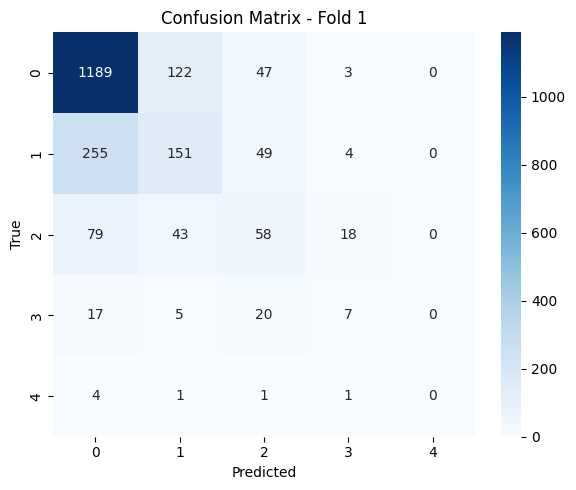

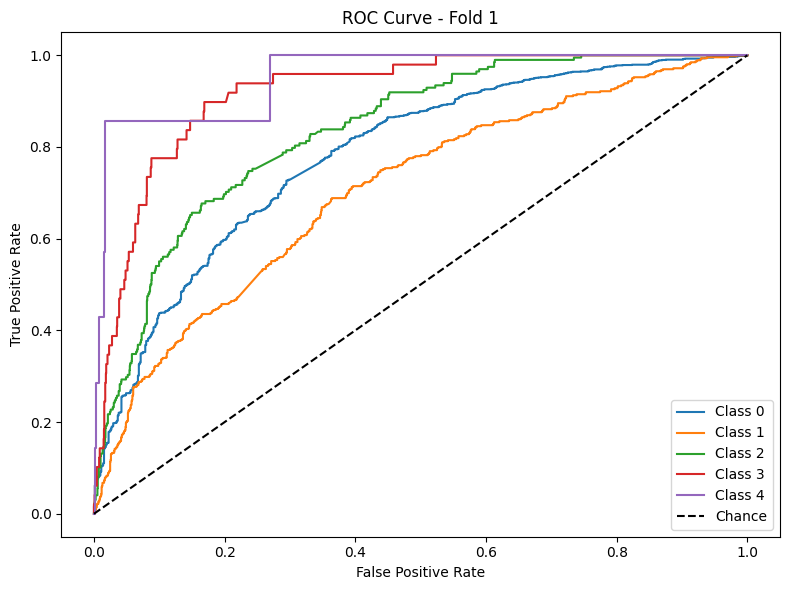


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1360
           1       0.47      0.27      0.34       459
           2       0.49      0.20      0.28       198
           3       0.44      0.44      0.44        50
           4       0.00      0.00      0.00         7

    accuracy                           0.70      2074
   macro avg       0.43      0.37      0.38      2074
weighted avg       0.65      0.70      0.66      2074



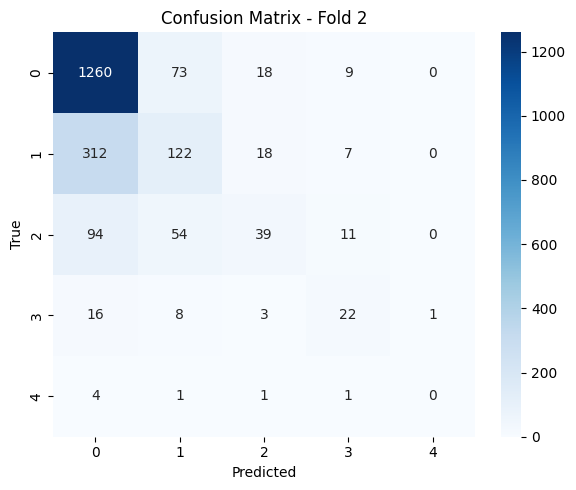

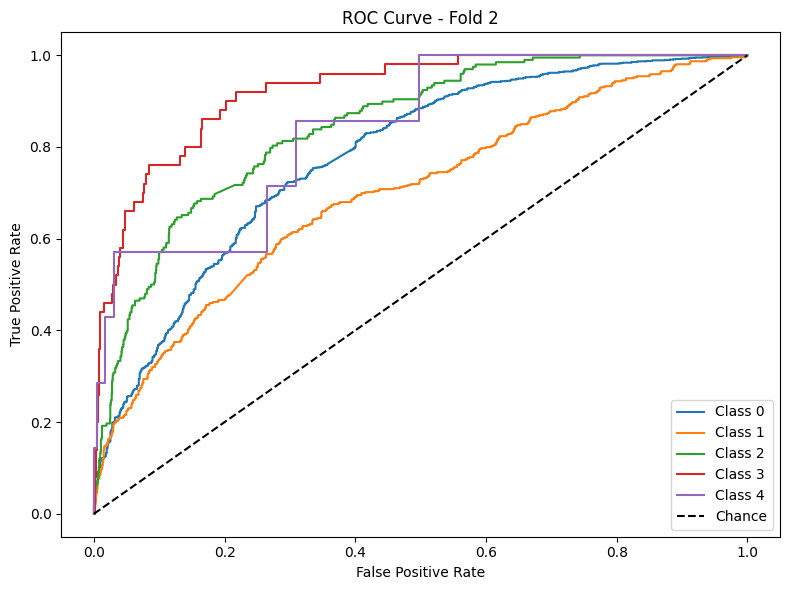


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81      1360
           1       0.49      0.32      0.39       459
           2       0.41      0.42      0.42       198
           3       0.43      0.30      0.35        50
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.42      0.38      0.39      2074
weighted avg       0.66      0.68      0.67      2074



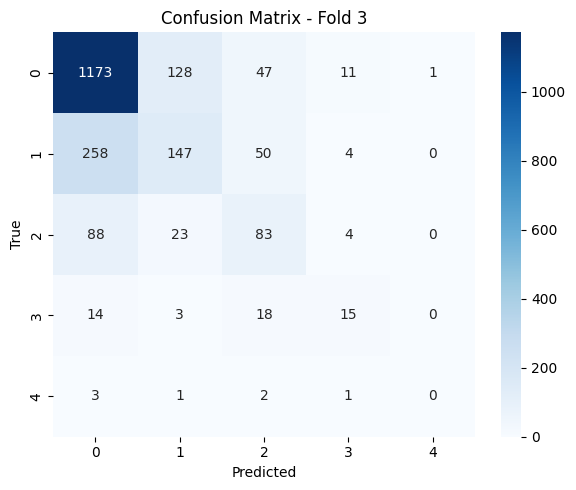

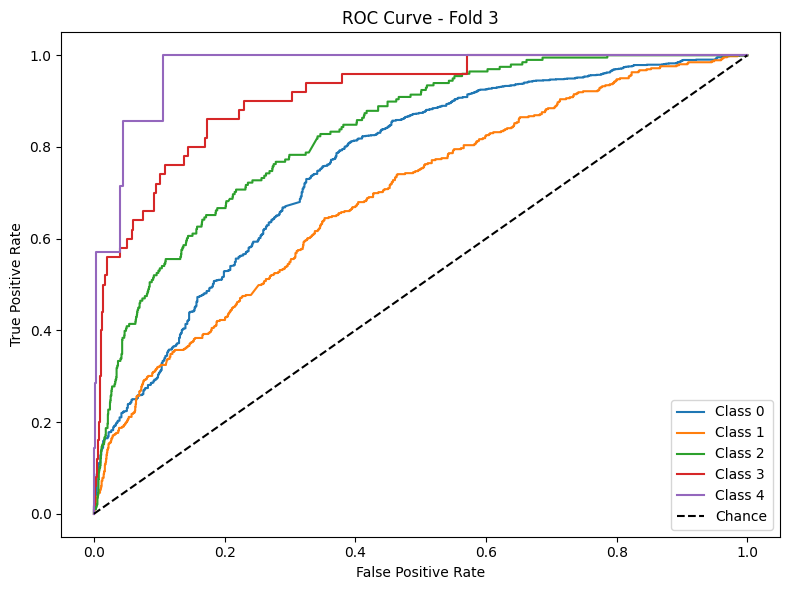


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      1360
           1       0.46      0.39      0.43       459
           2       0.47      0.35      0.40       198
           3       0.33      0.10      0.15        50
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.41      0.34      0.36      2074
weighted avg       0.66      0.68      0.66      2074



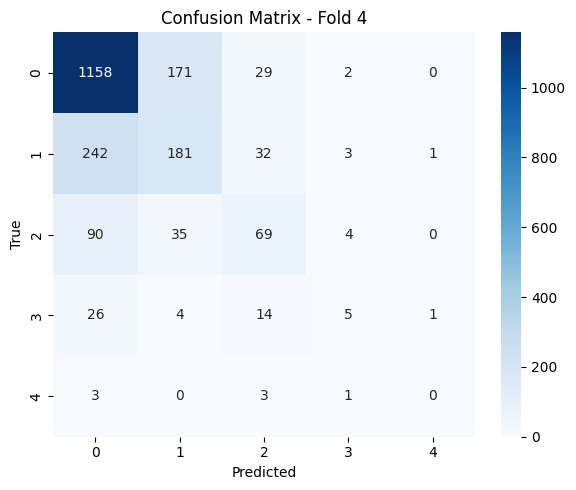

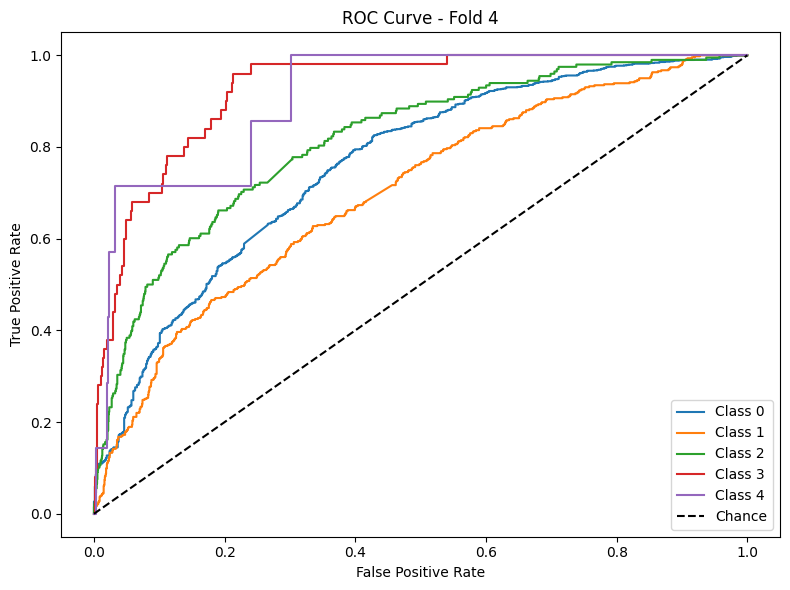


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.81      1360
           1       0.51      0.33      0.40       460
           2       0.44      0.37      0.40       197
           3       0.57      0.08      0.14        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2073
   macro avg       0.45      0.33      0.35      2073
weighted avg       0.66      0.68      0.66      2073



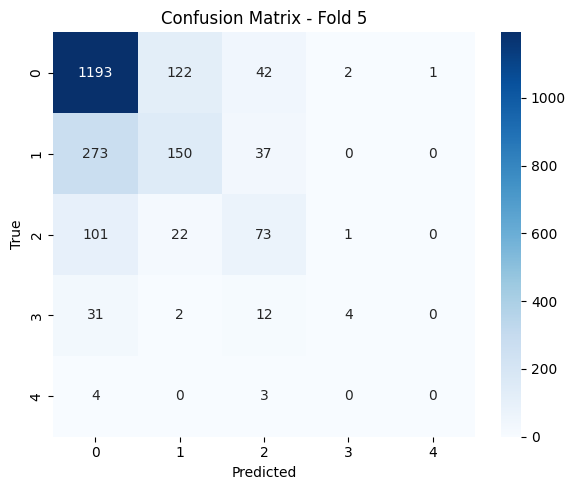

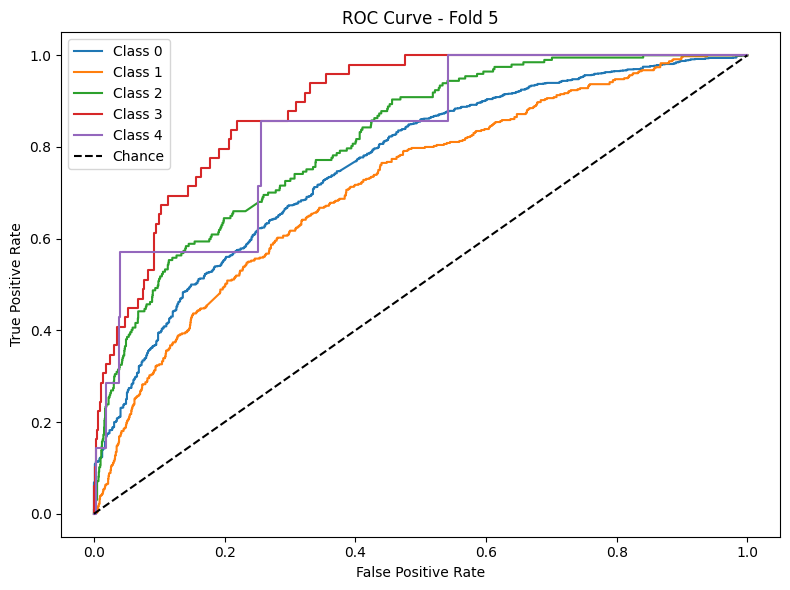


Average Accuracy: 0.6846
Average F1 Macro: 0.3629
Average AUC: 0.8231


============== Training Phase 4 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'relu'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1000
           1       0.51      0.35      0.42       355
           2       0.42      0.32      0.37       139
           3       0.45      0.26      0.33        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1539
   macro avg       0.43      0.36      0.39      1539
weighted avg       0.66      0.69      0.67      1539



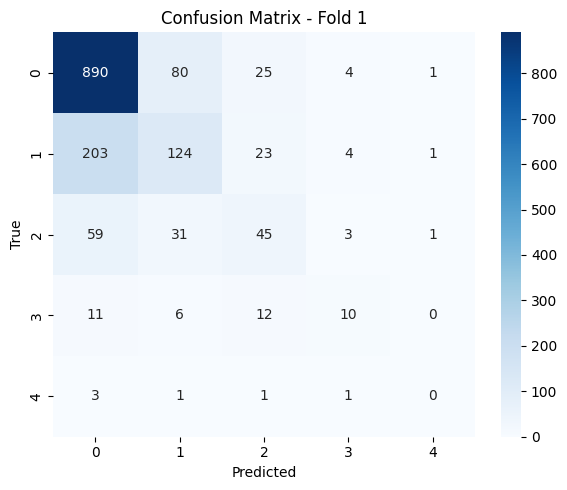

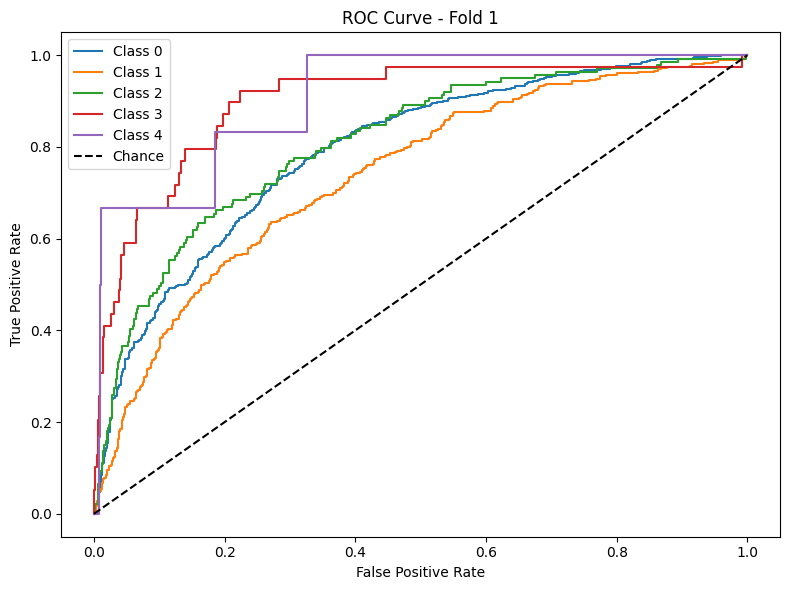


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1000
           1       0.65      0.26      0.38       355
           2       0.49      0.48      0.49       139
           3       0.35      0.17      0.23        40
           4       0.00      0.00      0.00         5

    accuracy                           0.71      1539
   macro avg       0.45      0.37      0.39      1539
weighted avg       0.69      0.71      0.68      1539



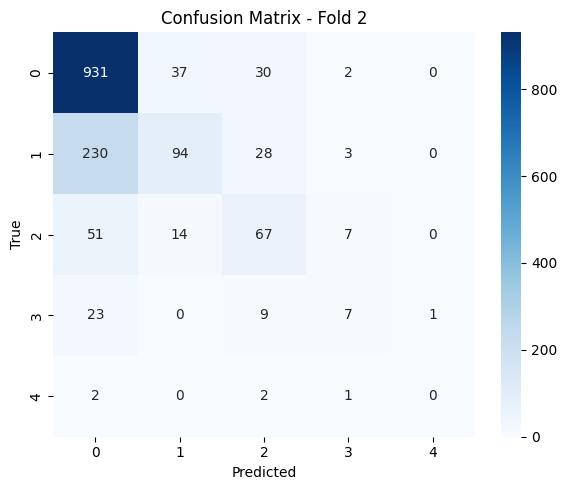

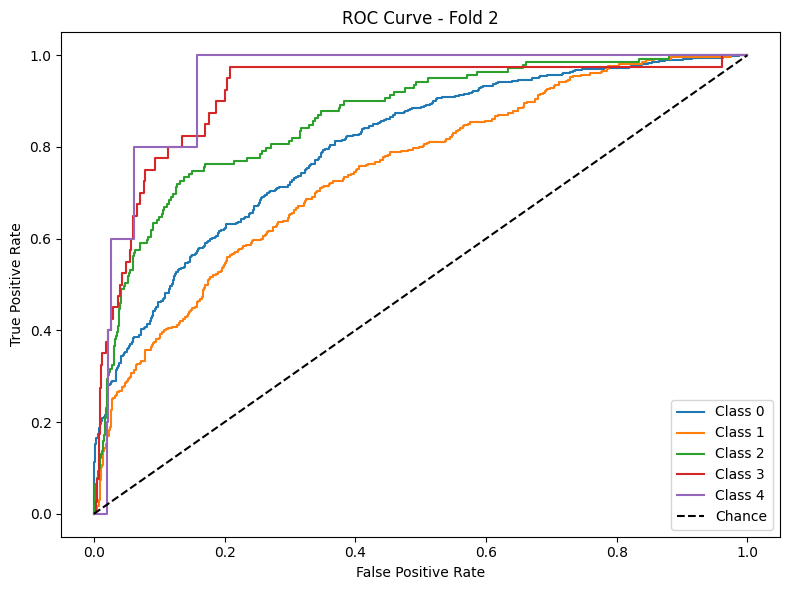


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84       999
           1       0.61      0.32      0.42       355
           2       0.54      0.40      0.46       139
           3       0.44      0.47      0.46        40
           4       0.33      0.17      0.22         6

    accuracy                           0.72      1539
   macro avg       0.54      0.46      0.48      1539
weighted avg       0.70      0.72      0.69      1539



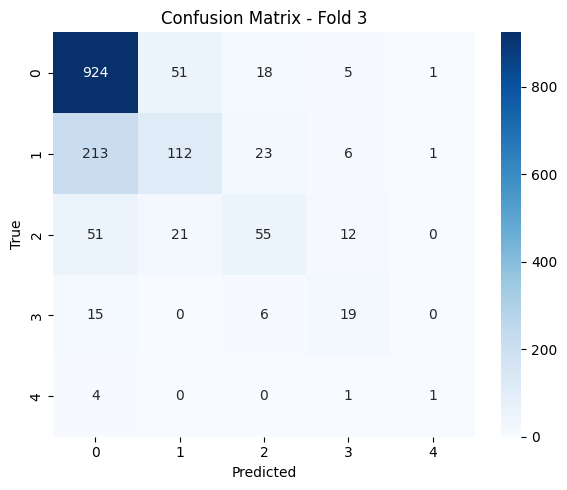

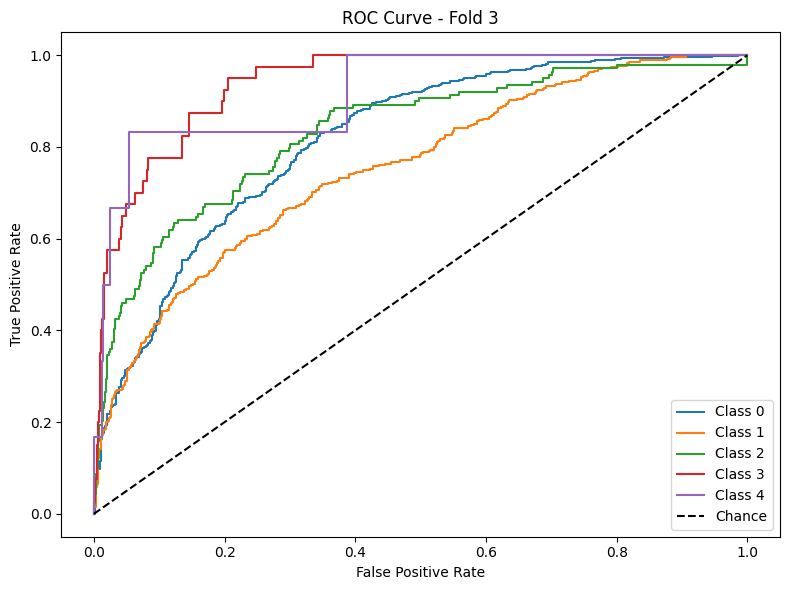


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.84       999
           1       0.59      0.27      0.37       356
           2       0.48      0.36      0.41       138
           3       0.29      0.31      0.30        39
           4       0.00      0.00      0.00         6

    accuracy                           0.71      1538
   macro avg       0.43      0.38      0.39      1538
weighted avg       0.68      0.71      0.68      1538



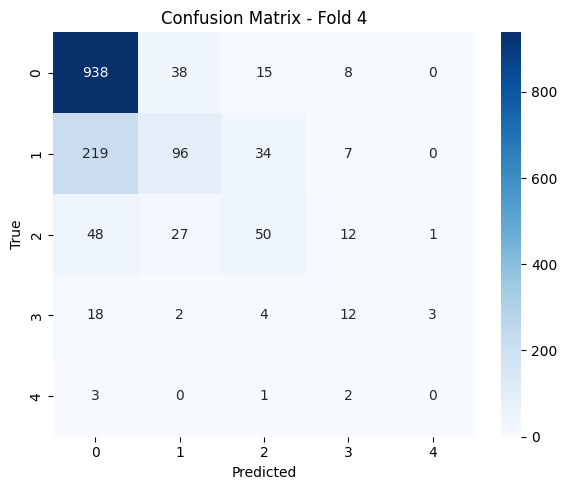

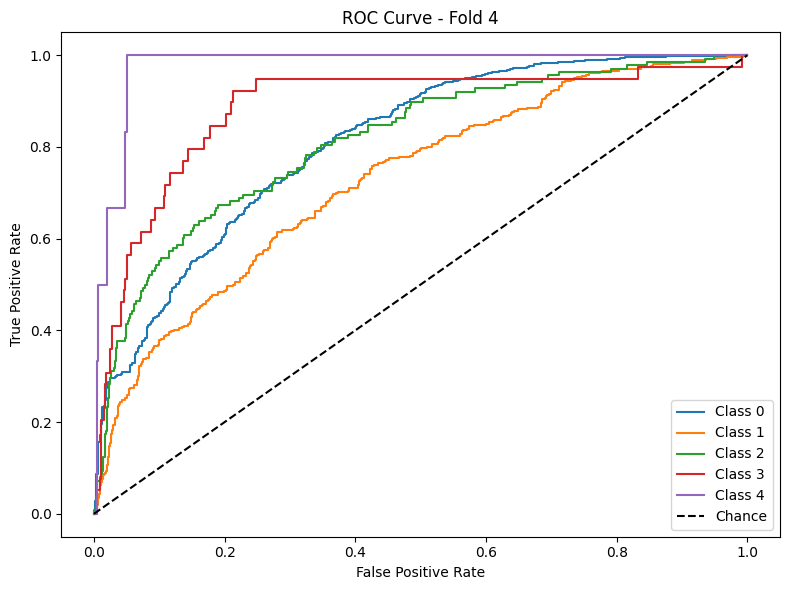


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       999
           1       0.56      0.52      0.54       356
           2       0.44      0.37      0.40       138
           3       0.47      0.41      0.44        39
           4       0.33      0.17      0.22         6

    accuracy                           0.72      1538
   macro avg       0.52      0.46      0.49      1538
weighted avg       0.71      0.72      0.71      1538



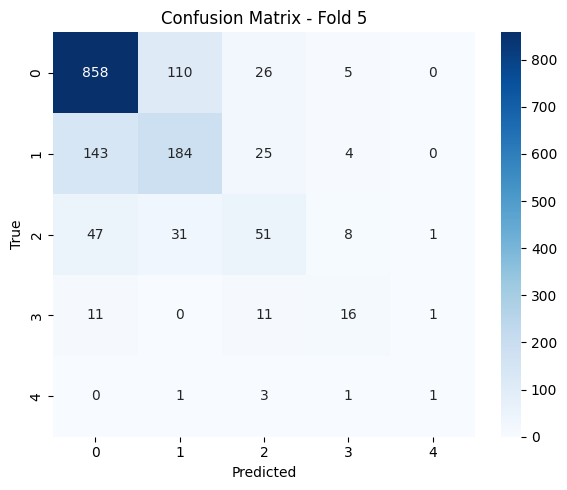

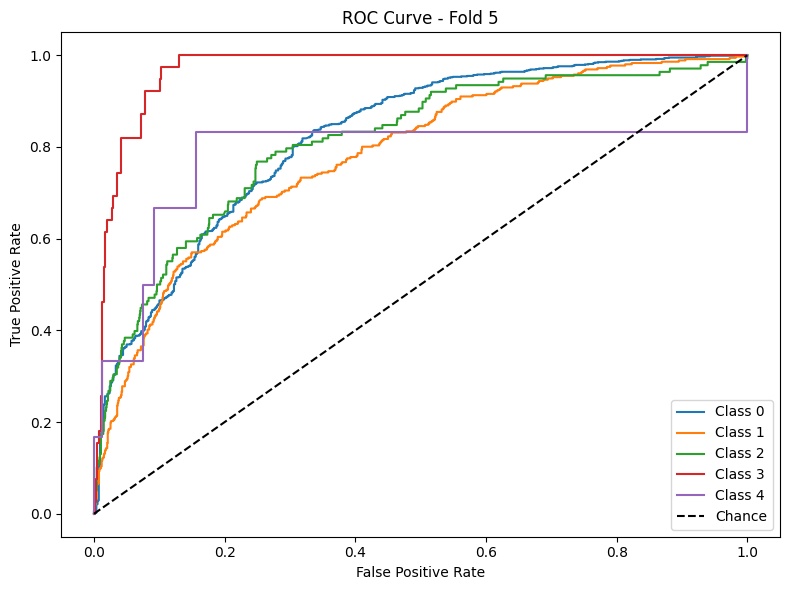


Average Accuracy: 0.7130
Average F1 Macro: 0.4245
Average AUC: 0.8420


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n================================================")
    print(f"\n============== Training Phase {i} ===============")
    print(f"\n=================================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       568
           1       0.18      0.21      0.19        63
           2       0.23      0.12      0.15        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.77       698
   macro avg       0.25      0.25      0.25       698
weighted avg       0.74      0.77      0.75       698



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


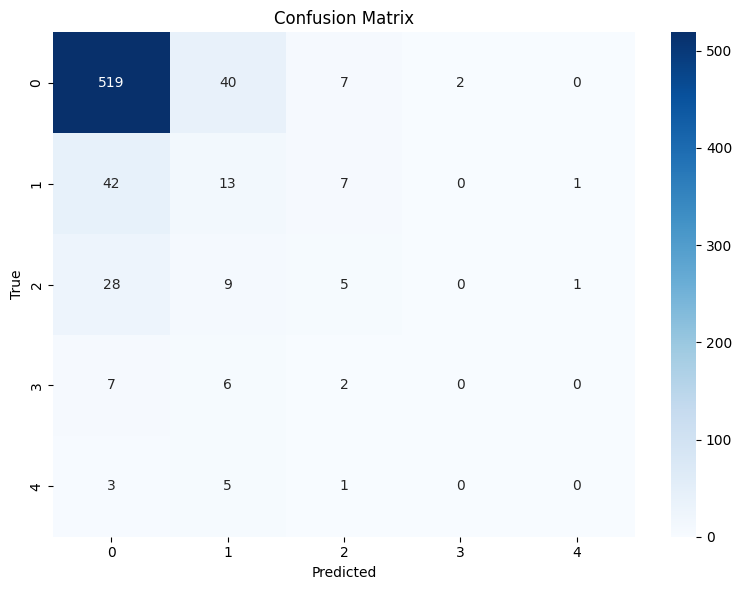


Test AUC (macro-average, OVR): 0.6772


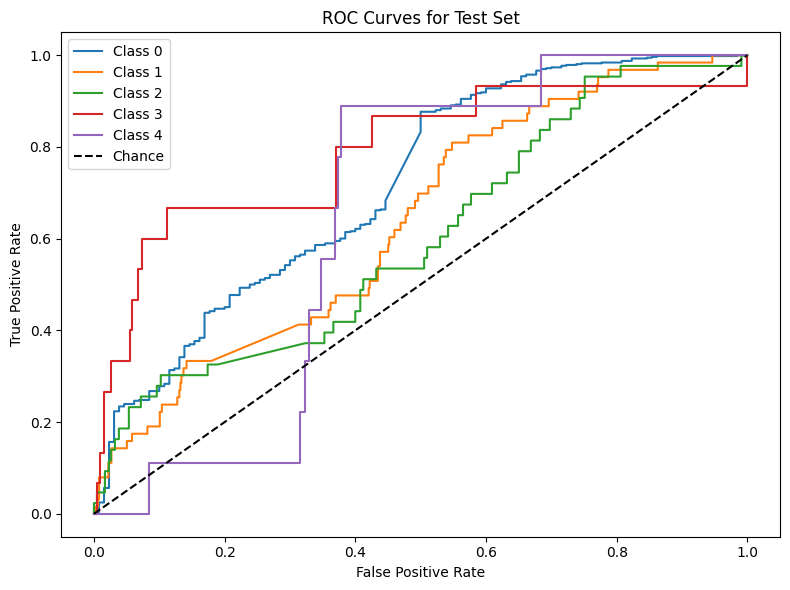

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       544
           1       0.23      0.34      0.27        59
           2       0.32      0.21      0.26        42
           3       0.00      0.00      0.00        14
           4       1.00      0.11      0.20         9

    accuracy                           0.78       668
   macro avg       0.49      0.31      0.33       668
weighted avg       0.78      0.78      0.78       668



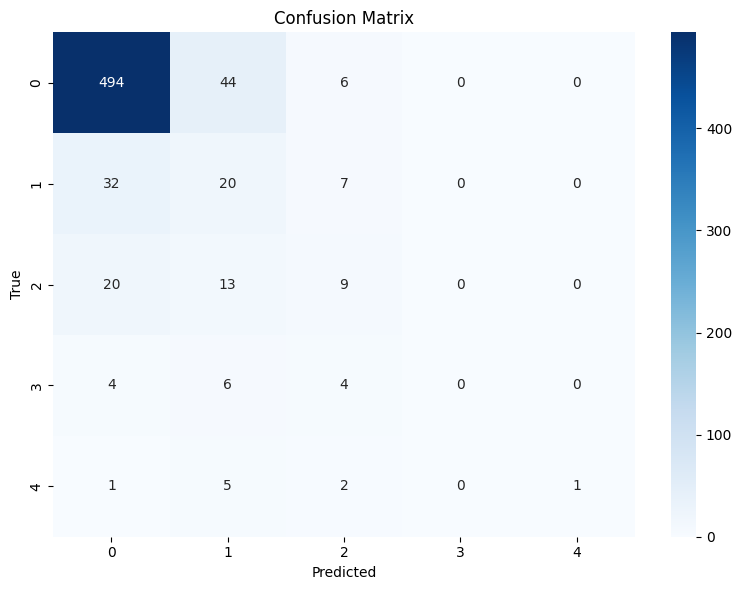


Test AUC (macro-average, OVR): 0.7976


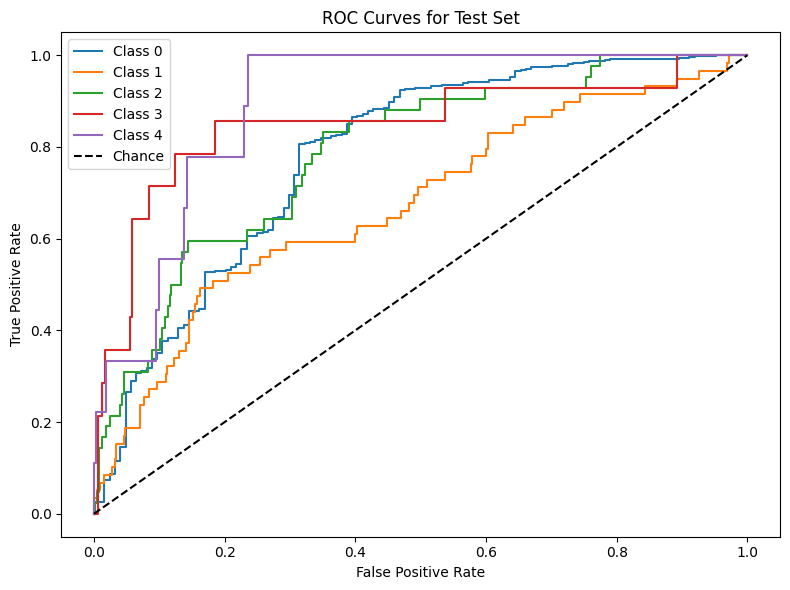

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       455
           1       0.12      0.13      0.13        52
           2       0.13      0.14      0.13        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.75       554
   macro avg       0.22      0.23      0.23       554
weighted avg       0.74      0.75      0.74       554



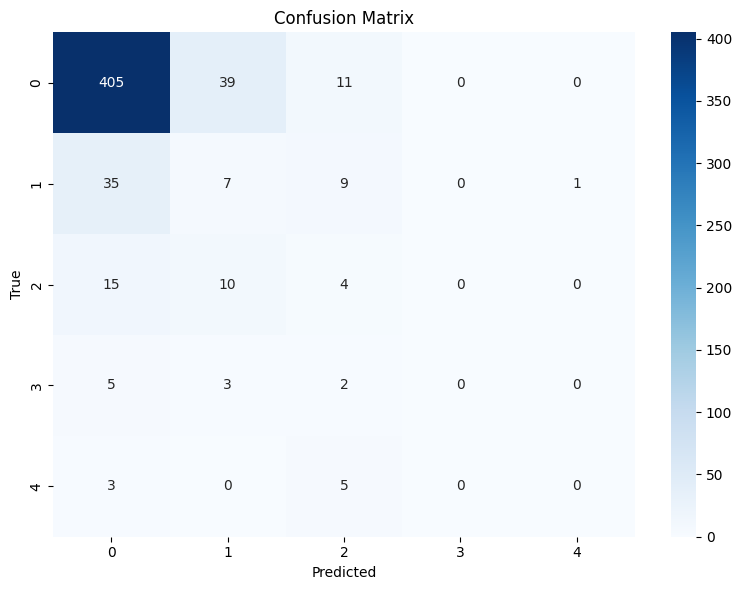


Test AUC (macro-average, OVR): 0.6948


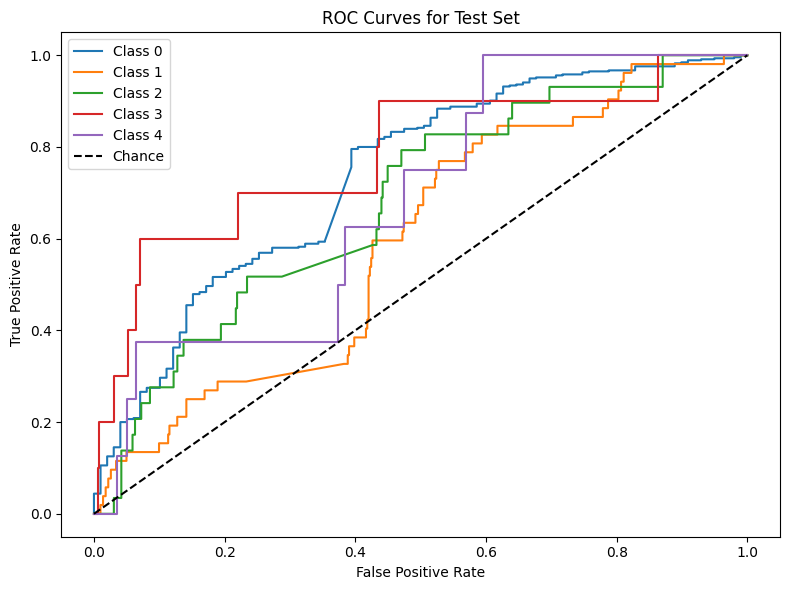

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.72      0.80       395
           1       0.12      0.38      0.18        40
           2       0.17      0.17      0.17        24
           3       0.50      0.20      0.29        10
           4       0.00      0.00      0.00         8

    accuracy                           0.64       477
   macro avg       0.34      0.29      0.29       477
weighted avg       0.78      0.64      0.70       477



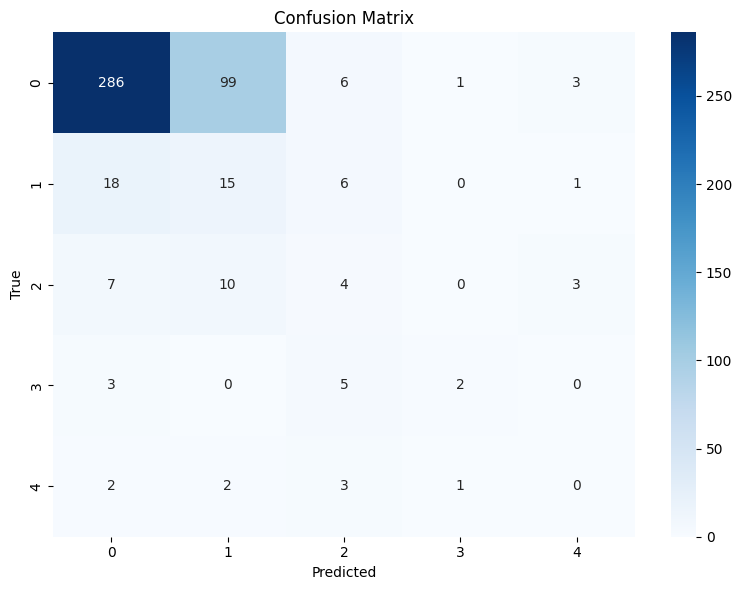


Test AUC (macro-average, OVR): 0.6865


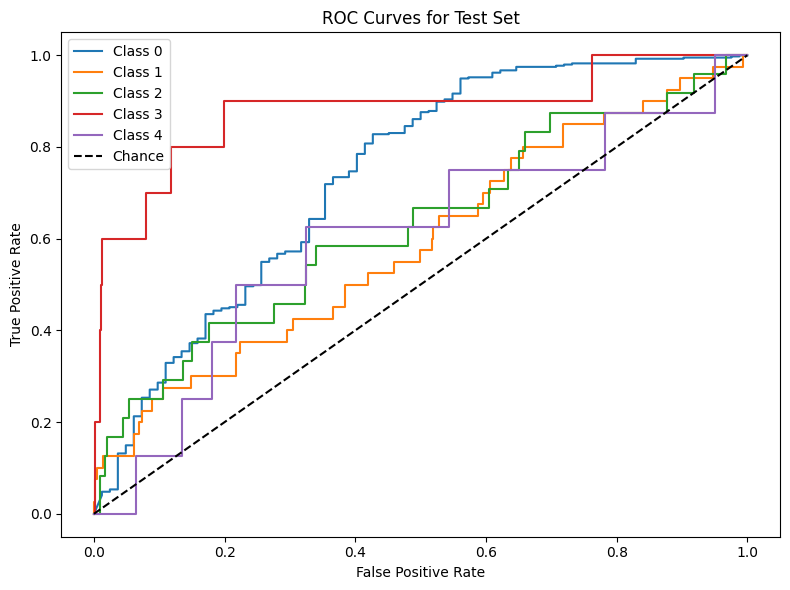

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'relu'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.77      1785
           1       0.47      0.56      0.51       604
           2       0.35      0.42      0.38       258
           3       0.18      0.54      0.27        59
           4       0.06      0.11      0.08         9

    accuracy                           0.64      2715
   macro avg       0.38      0.47      0.40      2715
weighted avg       0.70      0.64      0.66      2715



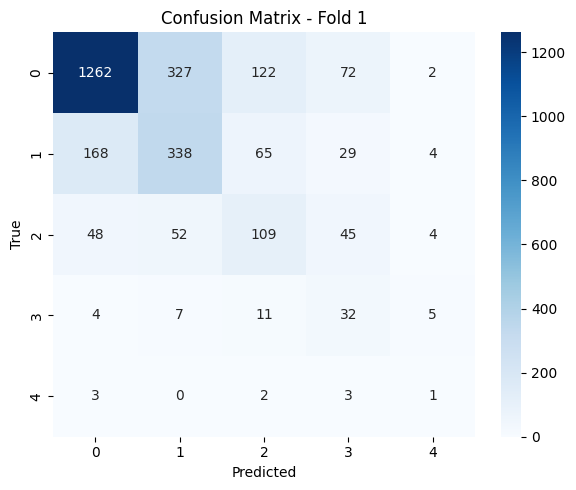

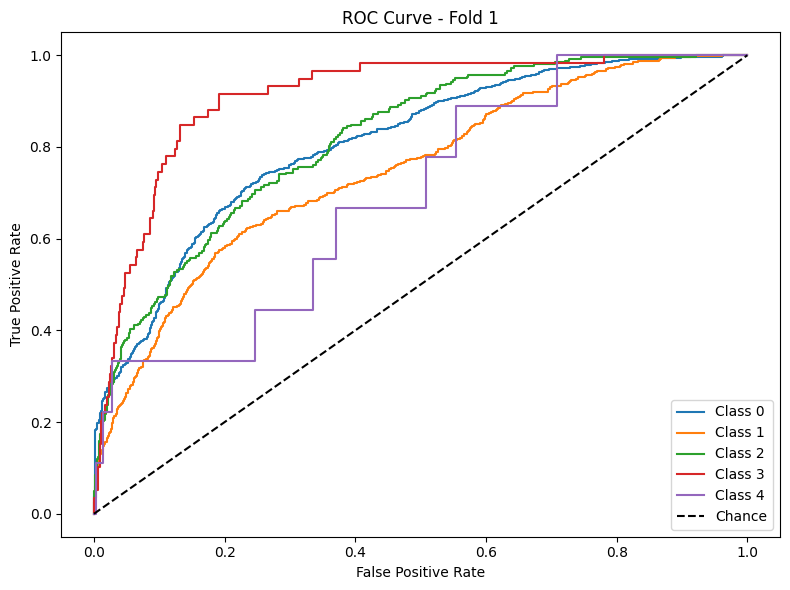

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.76      1786
           1       0.43      0.50      0.46       603
           2       0.35      0.49      0.41       258
           3       0.22      0.54      0.32        59
           4       0.24      0.50      0.32         8

    accuracy                           0.63      2714
   macro avg       0.41      0.54      0.45      2714
weighted avg       0.68      0.63      0.65      2714



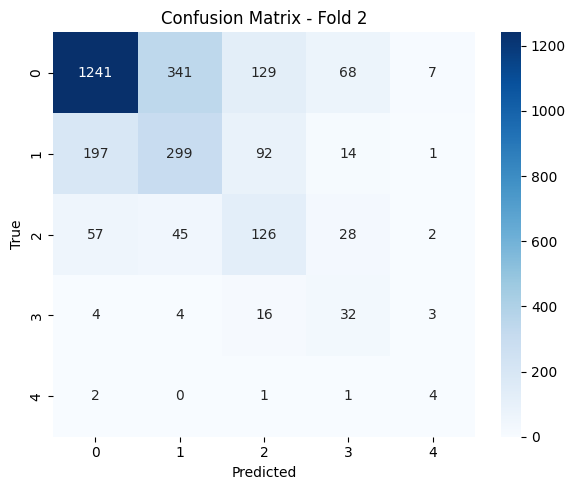

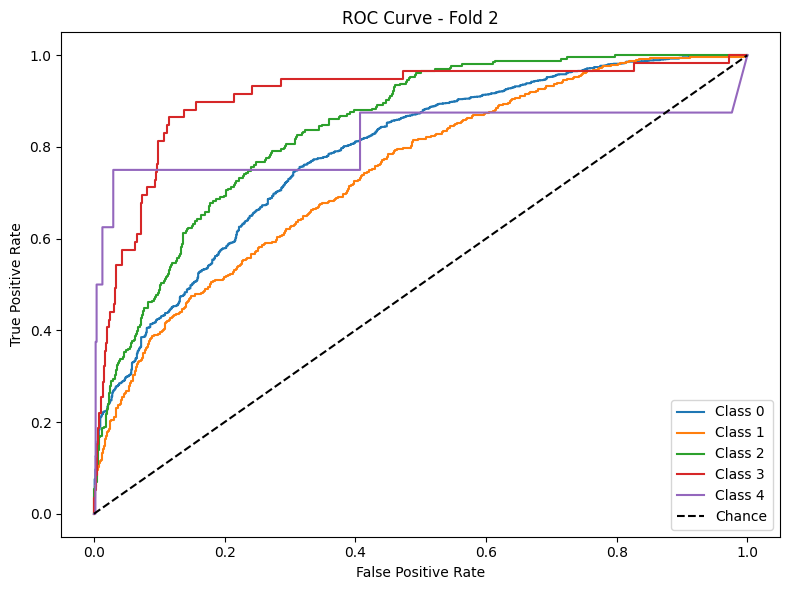


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.65      0.74      1786
           1       0.42      0.53      0.47       603
           2       0.34      0.48      0.40       258
           3       0.19      0.56      0.28        59
           4       0.12      0.62      0.20         8

    accuracy                           0.61      2714
   macro avg       0.38      0.57      0.42      2714
weighted avg       0.69      0.61      0.64      2714



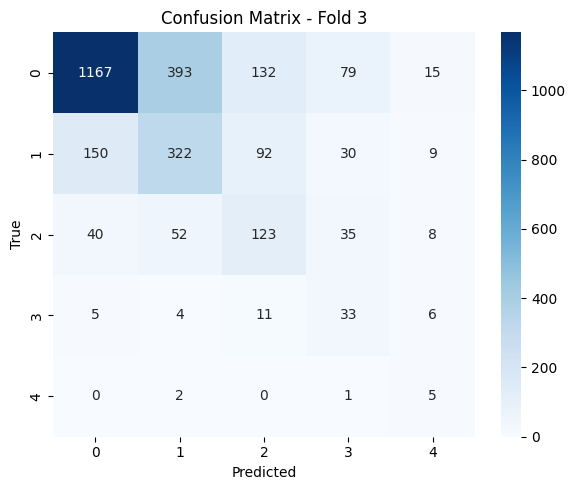

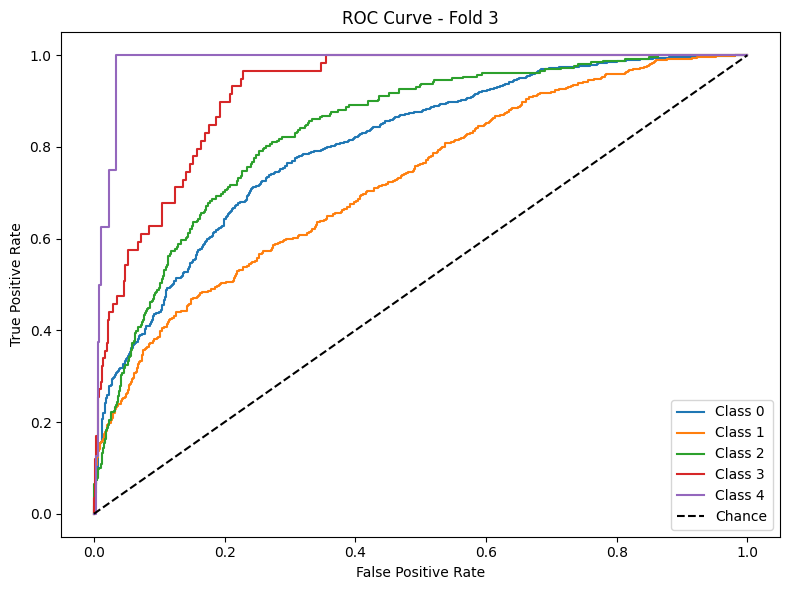


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78      1785
           1       0.45      0.51      0.48       603
           2       0.44      0.47      0.45       258
           3       0.19      0.51      0.27        59
           4       0.00      0.00      0.00         9

    accuracy                           0.65      2714
   macro avg       0.38      0.44      0.40      2714
weighted avg       0.69      0.65      0.67      2714



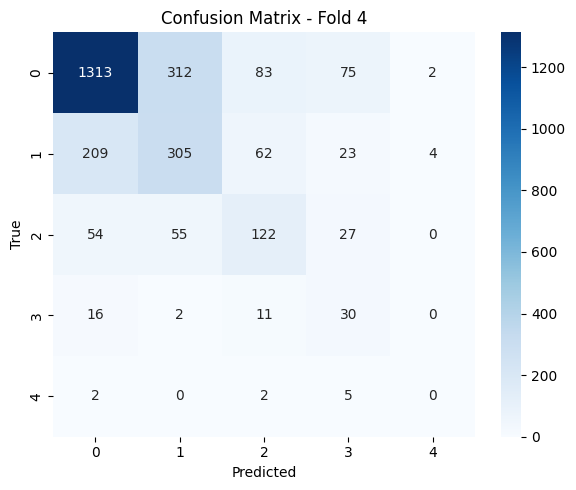

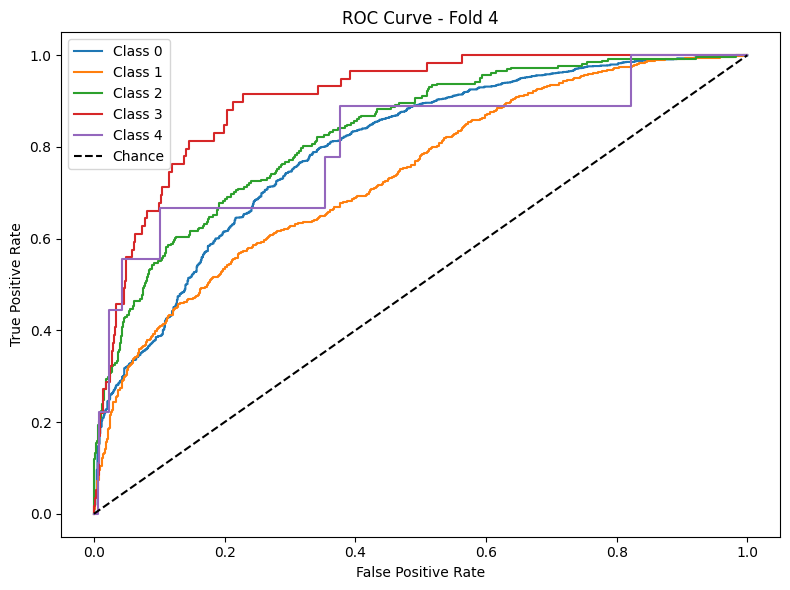


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      1785
           1       0.51      0.46      0.48       603
           2       0.36      0.49      0.42       258
           3       0.19      0.56      0.29        59
           4       0.25      0.22      0.24         9

    accuracy                           0.66      2714
   macro avg       0.43      0.50      0.44      2714
weighted avg       0.70      0.66      0.67      2714



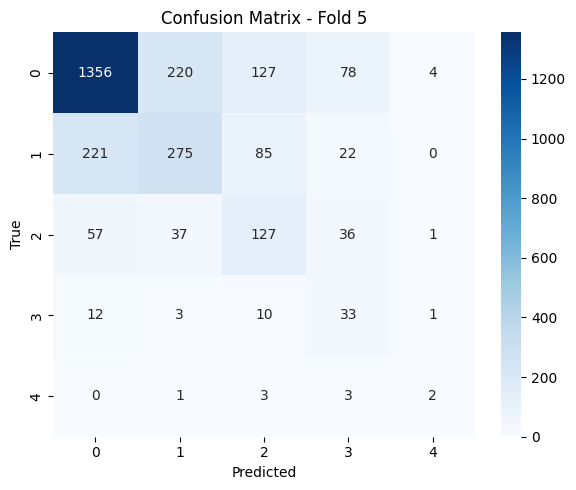

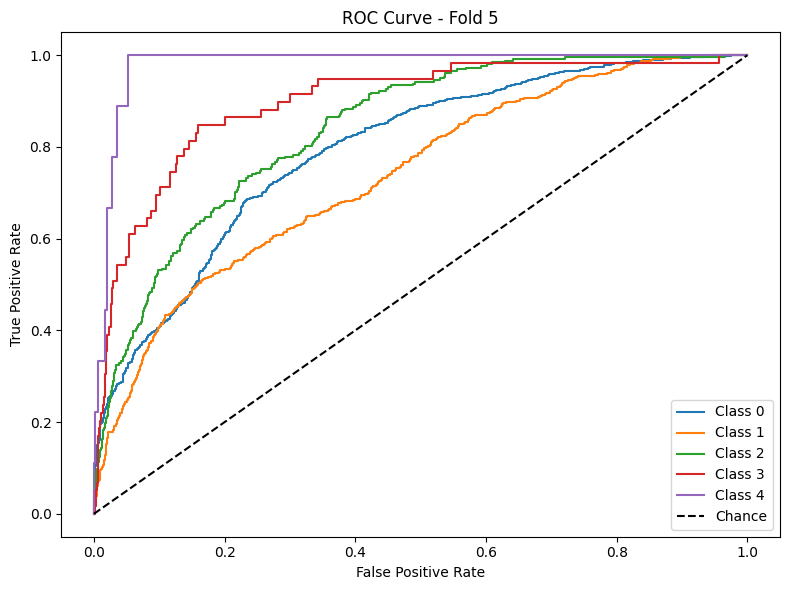


Average Accuracy: 0.6379
Average F1 Macro: 0.4219
Average AUC: 0.8266

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'logistic'}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76      1489
           1       0.38      0.43      0.40       488
           2       0.33      0.40      0.37       220
           3       0.18      0.61      0.28        54
           4       0.11      0.11      0.11         9

    accuracy                           0.61      2260
   macro avg       0.37      0.45      0.38      2260
weighted avg       0.67      0.61      0.63      2260



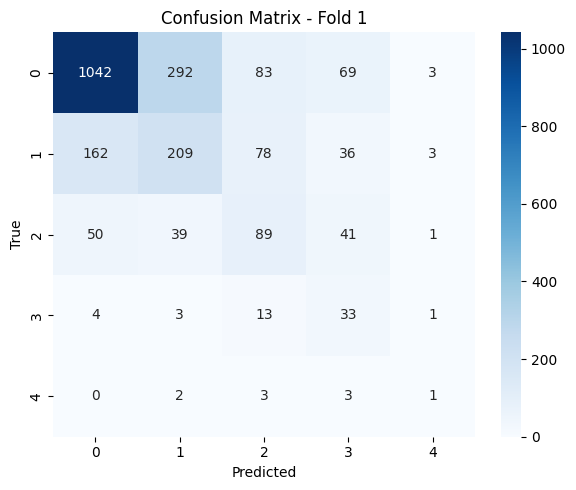

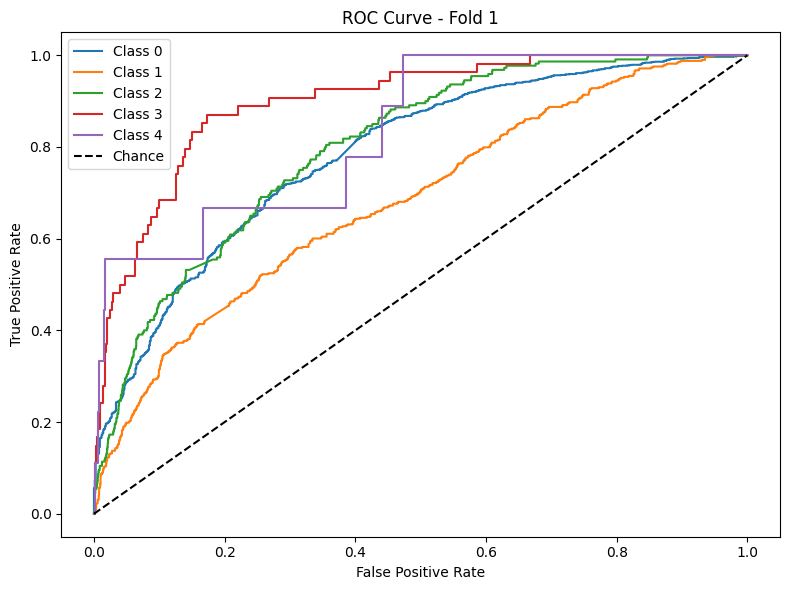

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.65      0.73      1489
           1       0.38      0.53      0.44       489
           2       0.35      0.47      0.40       219
           3       0.22      0.49      0.31        55
           4       0.50      0.38      0.43         8

    accuracy                           0.60      2260
   macro avg       0.46      0.50      0.46      2260
weighted avg       0.67      0.60      0.62      2260



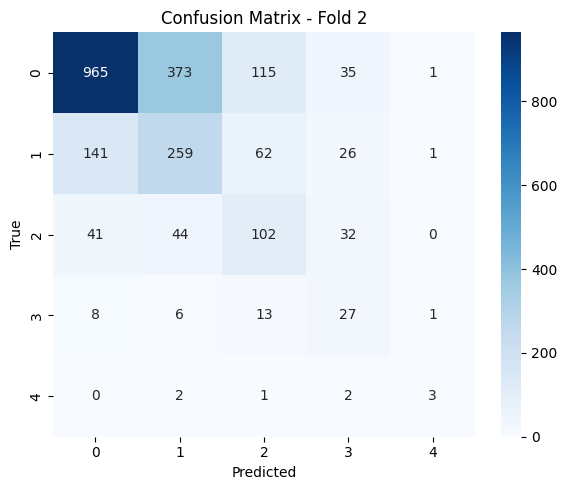

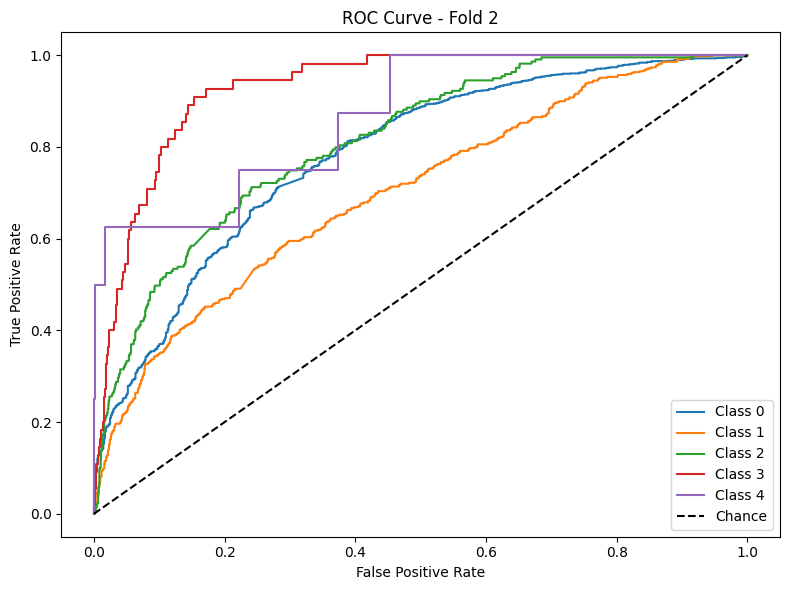


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.63      0.71      1489
           1       0.35      0.51      0.41       489
           2       0.36      0.42      0.39       219
           3       0.17      0.39      0.24        54
           4       0.21      0.50      0.30         8

    accuracy                           0.58      2259
   macro avg       0.38      0.49      0.41      2259
weighted avg       0.66      0.58      0.61      2259



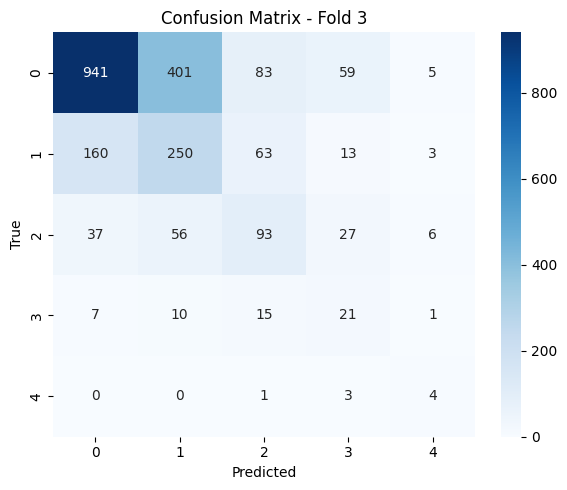

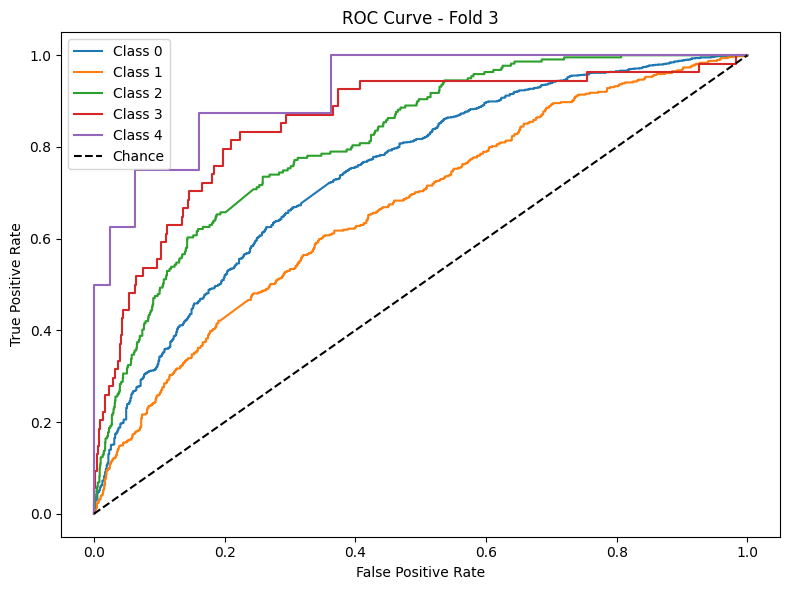


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.62      0.72      1489
           1       0.39      0.54      0.45       489
           2       0.33      0.50      0.39       219
           3       0.25      0.56      0.34        54
           4       0.12      0.38      0.19         8

    accuracy                           0.59      2259
   macro avg       0.39      0.52      0.42      2259
weighted avg       0.68      0.59      0.62      2259



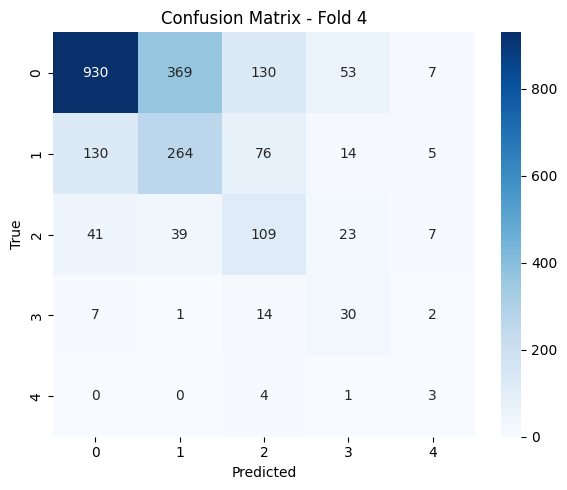

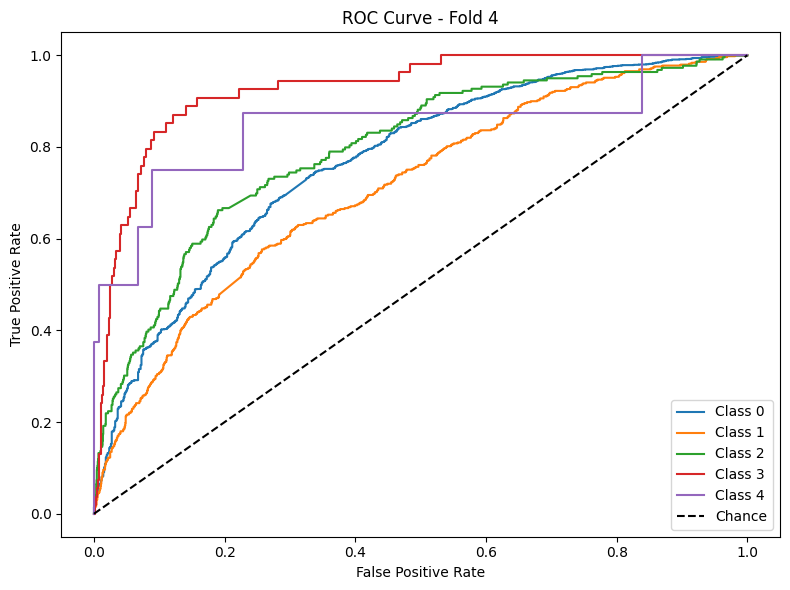


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.66      0.74      1490
           1       0.38      0.52      0.44       488
           2       0.38      0.51      0.43       219
           3       0.13      0.30      0.18        54
           4       0.09      0.25      0.13         8

    accuracy                           0.60      2259
   macro avg       0.36      0.45      0.38      2259
weighted avg       0.68      0.60      0.63      2259



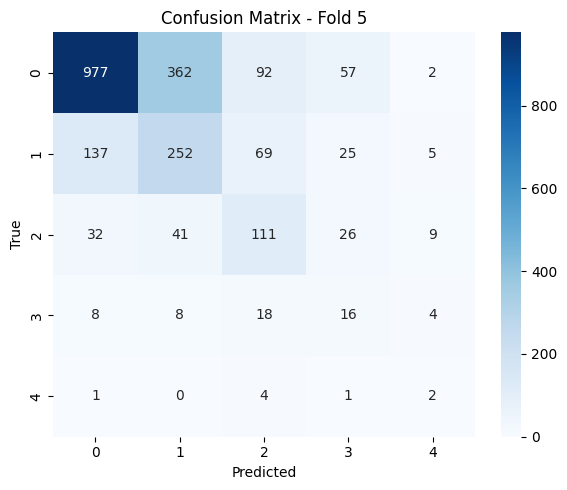

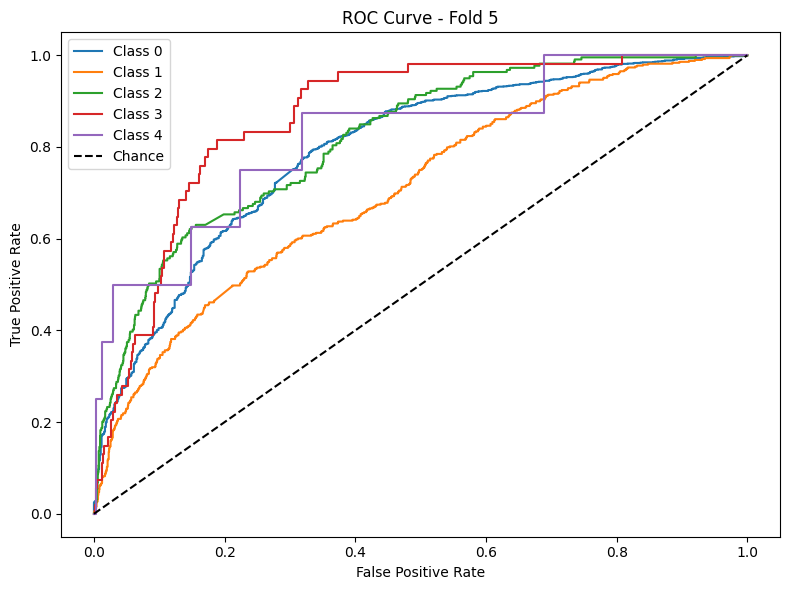


Average Accuracy: 0.5960
Average F1 Macro: 0.4119
Average AUC: 0.8057

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'logistic'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.76      0.80      1361
           1       0.50      0.45      0.47       459
           2       0.35      0.50      0.41       198
           3       0.20      0.51      0.28        49
           4       0.14      0.57      0.23         7

    accuracy                           0.66      2074
   macro avg       0.41      0.56      0.44      2074
weighted avg       0.71      0.66      0.68      2074



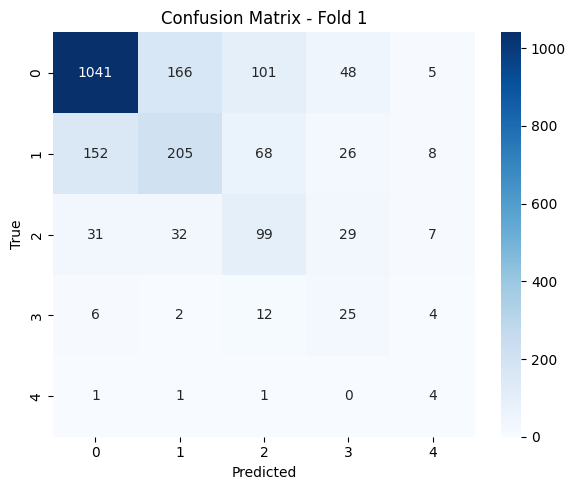

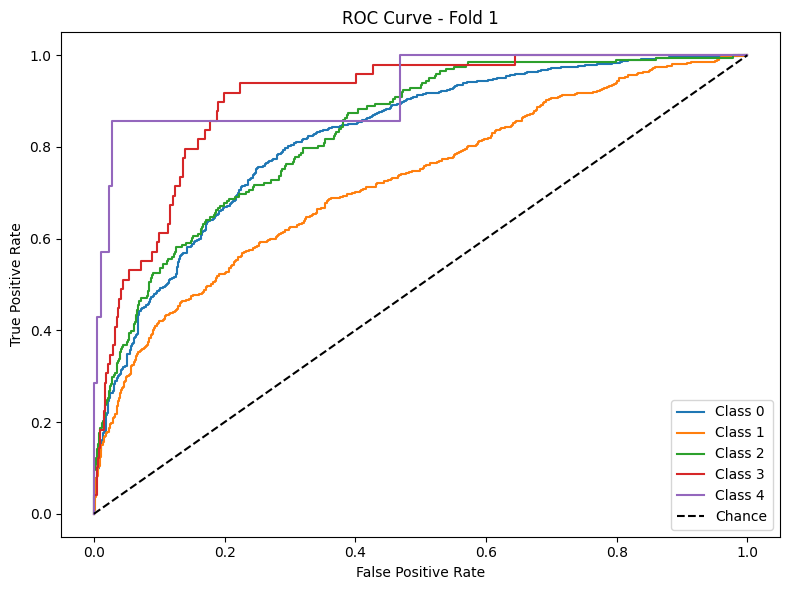


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.77      1360
           1       0.43      0.48      0.45       459
           2       0.41      0.55      0.47       198
           3       0.23      0.58      0.33        50
           4       0.04      0.14      0.06         7

    accuracy                           0.64      2074
   macro avg       0.39      0.49      0.42      2074
weighted avg       0.70      0.64      0.66      2074



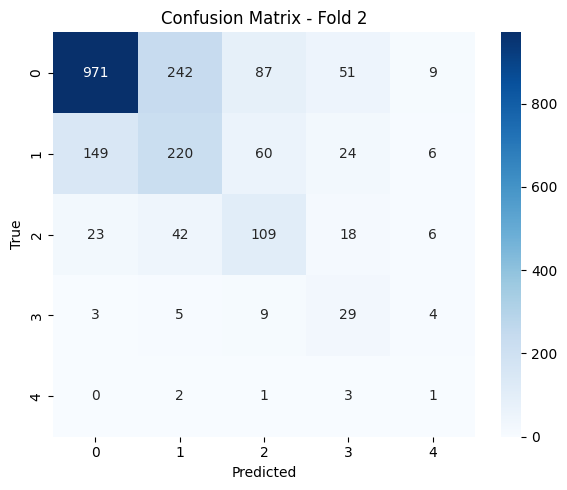

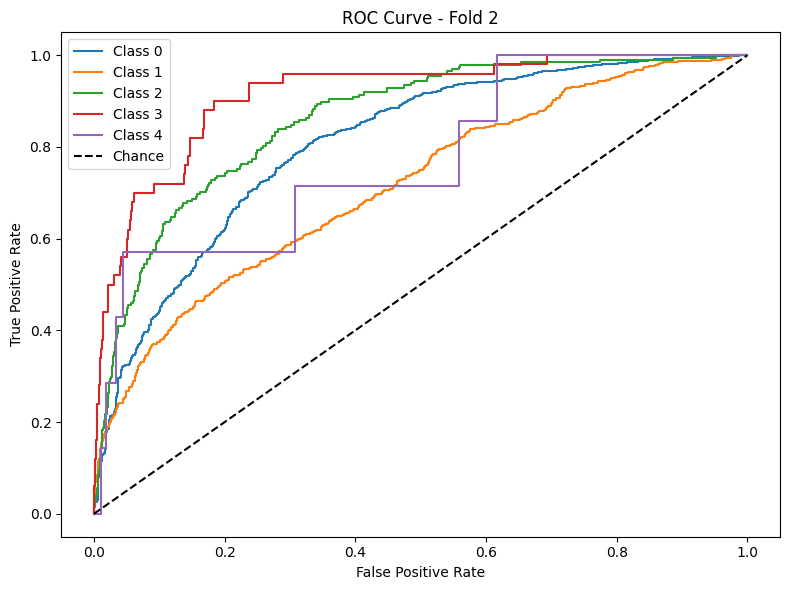

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      1360
           1       0.46      0.42      0.44       459
           2       0.35      0.52      0.42       198
           3       0.17      0.52      0.26        50
           4       0.10      0.43      0.16         7

    accuracy                           0.63      2074
   macro avg       0.38      0.52      0.41      2074
weighted avg       0.69      0.63      0.65      2074



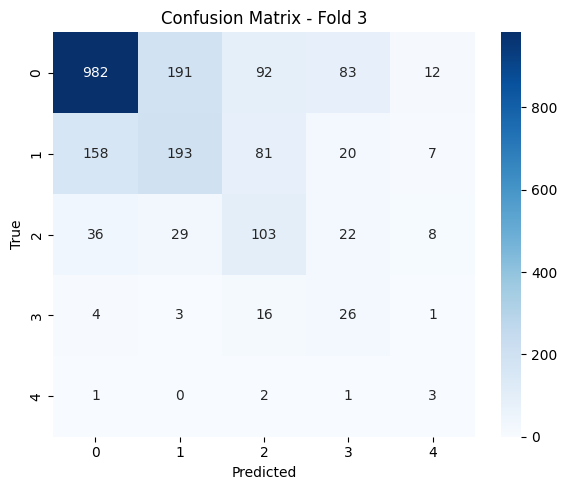

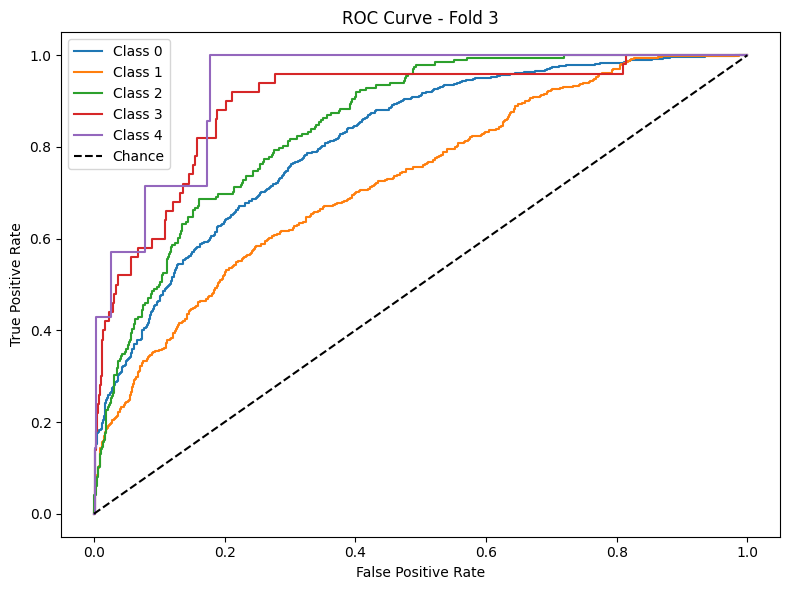

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78      1360
           1       0.45      0.46      0.45       459
           2       0.36      0.46      0.41       198
           3       0.25      0.56      0.35        50
           4       0.05      0.14      0.07         7

    accuracy                           0.64      2074
   macro avg       0.39      0.47      0.41      2074
weighted avg       0.68      0.64      0.66      2074



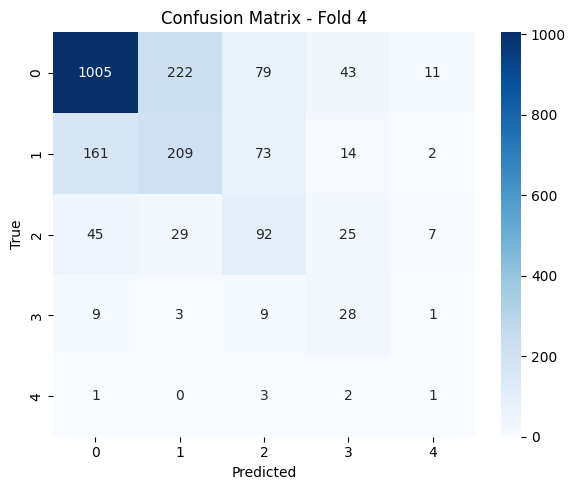

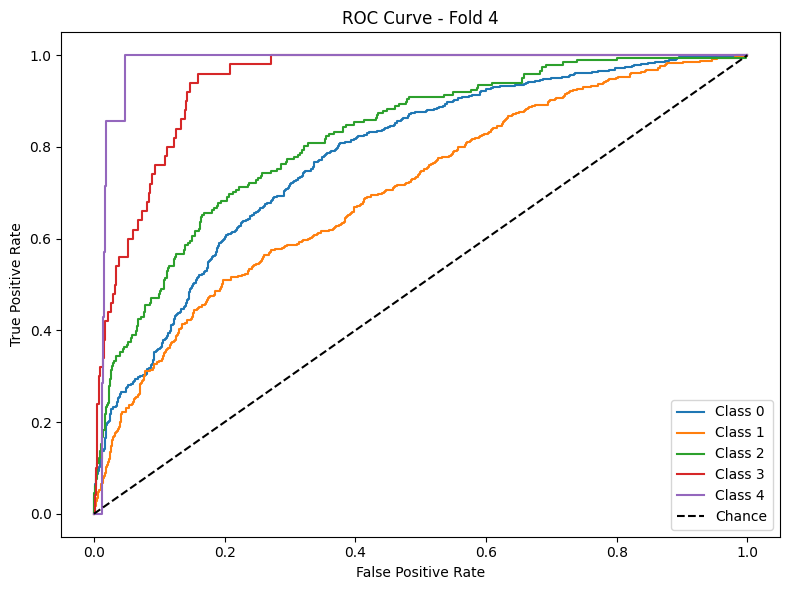

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.68      0.74      1360
           1       0.41      0.51      0.46       460
           2       0.35      0.48      0.40       197
           3       0.19      0.37      0.25        49
           4       0.08      0.29      0.12         7

    accuracy                           0.61      2073
   macro avg       0.37      0.46      0.40      2073
weighted avg       0.67      0.61      0.63      2073



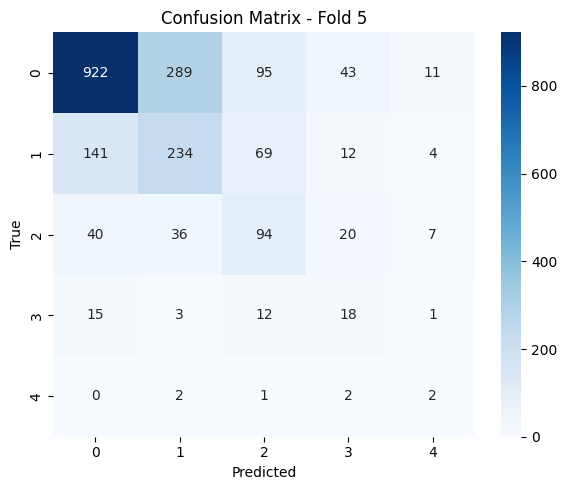

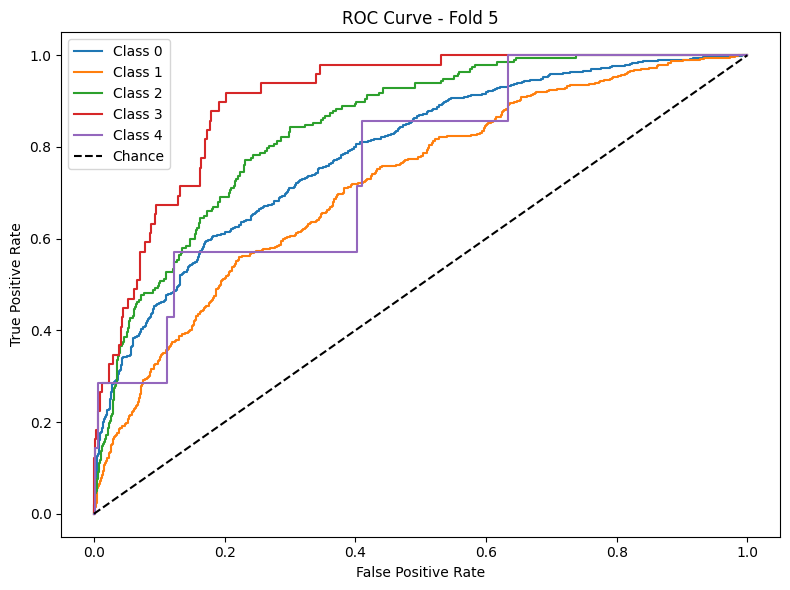


Average Accuracy: 0.6381
Average F1 Macro: 0.4148
Average AUC: 0.8295

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'logistic'}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78      1000
           1       0.47      0.46      0.47       355
           2       0.36      0.45      0.40       139
           3       0.23      0.46      0.31        39
           4       0.11      0.33      0.17         6

    accuracy                           0.65      1539
   macro avg       0.40      0.49      0.42      1539
weighted avg       0.68      0.65      0.66      1539



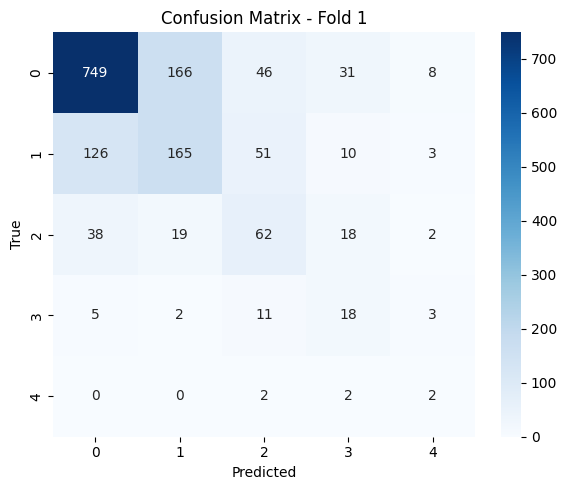

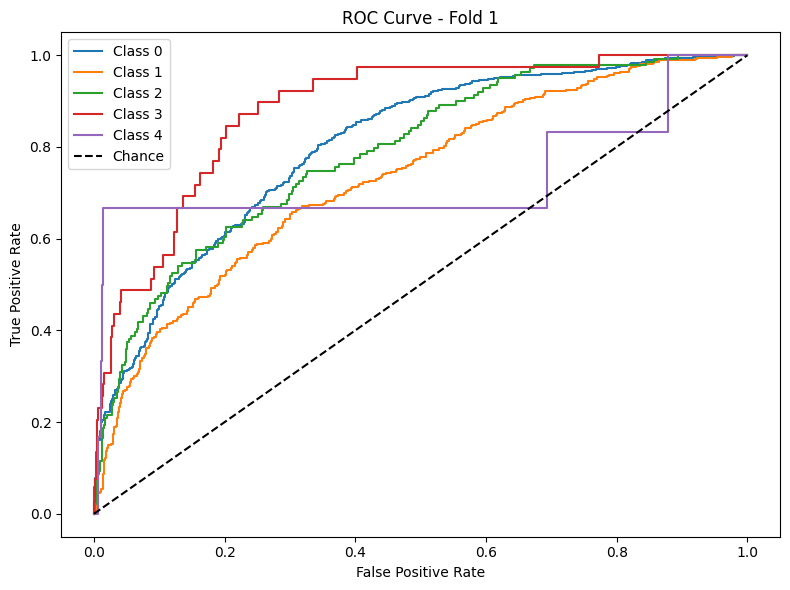

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.76      1000
           1       0.44      0.47      0.46       355
           2       0.42      0.46      0.44       139
           3       0.26      0.53      0.35        40
           4       0.05      0.20      0.08         5

    accuracy                           0.64      1539
   macro avg       0.39      0.48      0.42      1539
weighted avg       0.67      0.64      0.65      1539



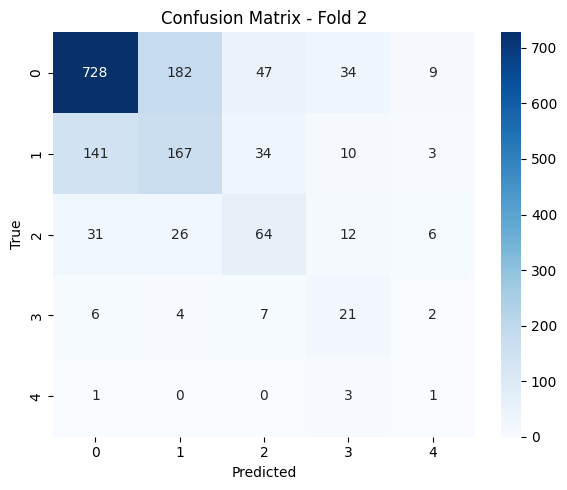

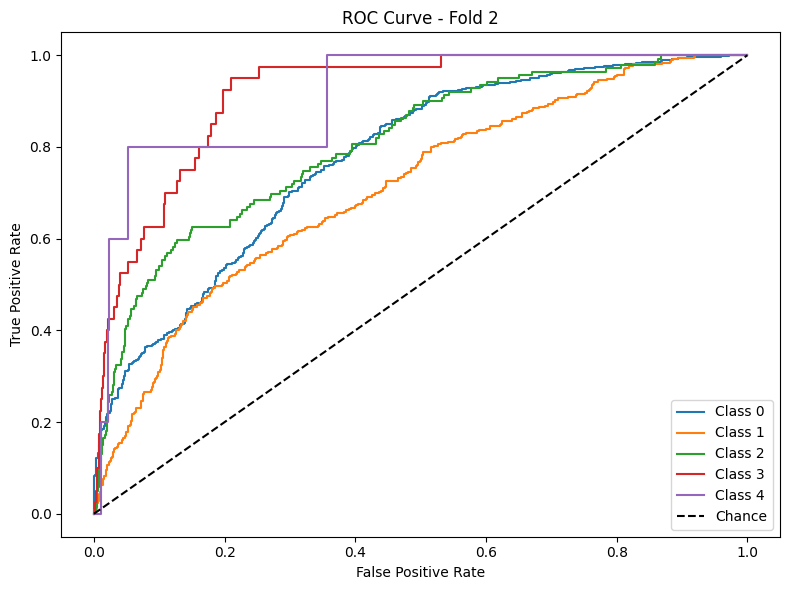

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.67      0.74       999
           1       0.42      0.56      0.48       355
           2       0.42      0.55      0.48       139
           3       0.29      0.47      0.36        40
           4       0.17      0.50      0.25         6

    accuracy                           0.63      1539
   macro avg       0.43      0.55      0.46      1539
weighted avg       0.68      0.63      0.64      1539



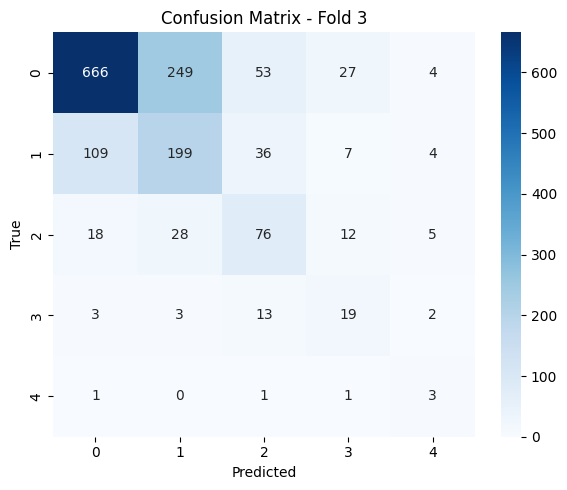

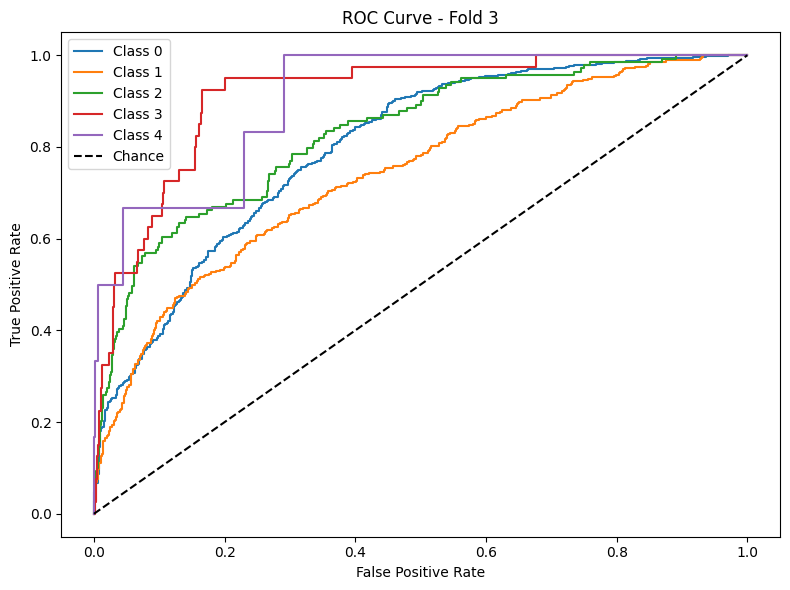

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.67      0.74       999
           1       0.43      0.53      0.47       356
           2       0.31      0.49      0.38       138
           3       0.27      0.49      0.35        39
           4       0.33      0.50      0.40         6

    accuracy                           0.62      1538
   macro avg       0.44      0.54      0.47      1538
weighted avg       0.68      0.62      0.64      1538



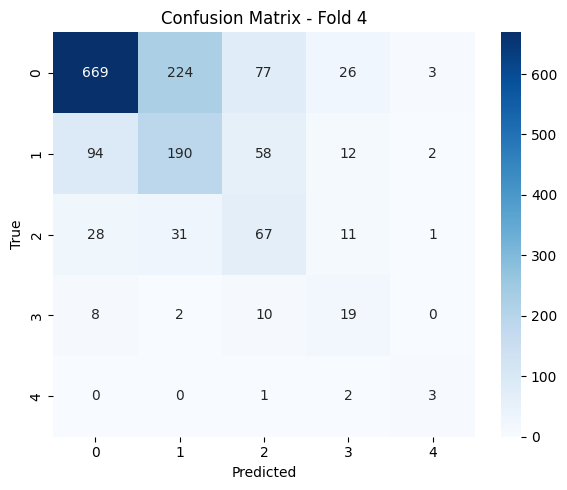

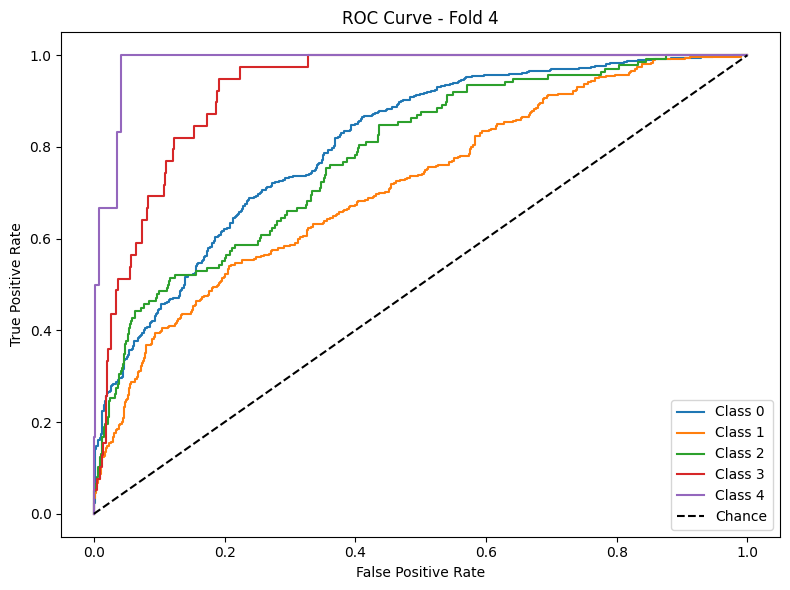

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77       999
           1       0.46      0.51      0.48       356
           2       0.33      0.43      0.37       138
           3       0.33      0.62      0.43        39
           4       0.06      0.17      0.09         6

    accuracy                           0.64      1538
   macro avg       0.40      0.49      0.43      1538
weighted avg       0.68      0.64      0.66      1538



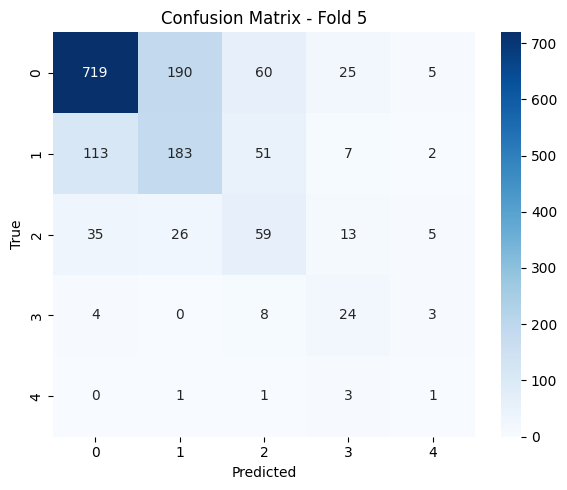

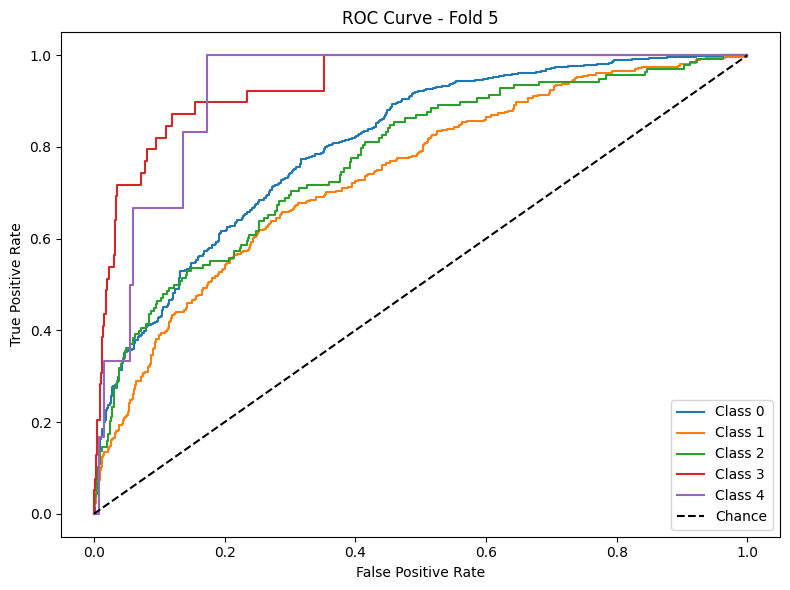


Average Accuracy: 0.6336
Average F1 Macro: 0.4402
Average AUC: 0.8252


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       568
           1       0.10      0.21      0.14        63
           2       0.17      0.30      0.21        43
           3       0.25      0.20      0.22        15
           4       0.00      0.00      0.00         9

    accuracy                           0.65       698
   macro avg       0.28      0.29      0.28       698
weighted avg       0.74      0.65      0.68       698



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1

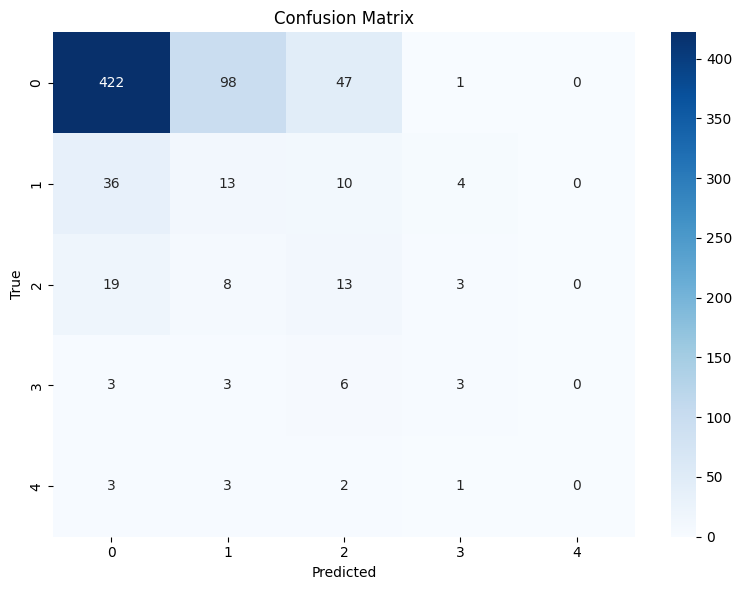


Test AUC (macro-average, OVR): 0.6189


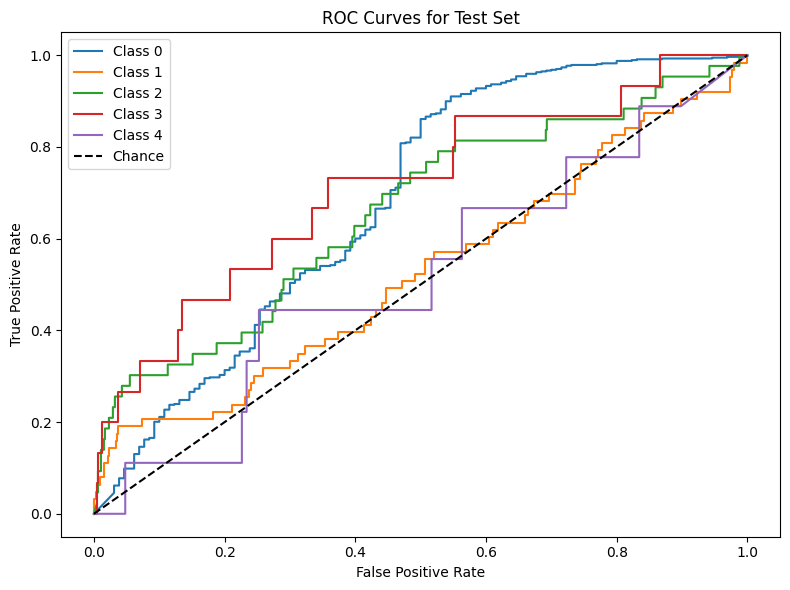

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.58      0.70       544
           1       0.09      0.41      0.15        59
           2       0.28      0.26      0.27        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.53       668
   macro avg       0.25      0.25      0.22       668
weighted avg       0.74      0.53      0.60       668



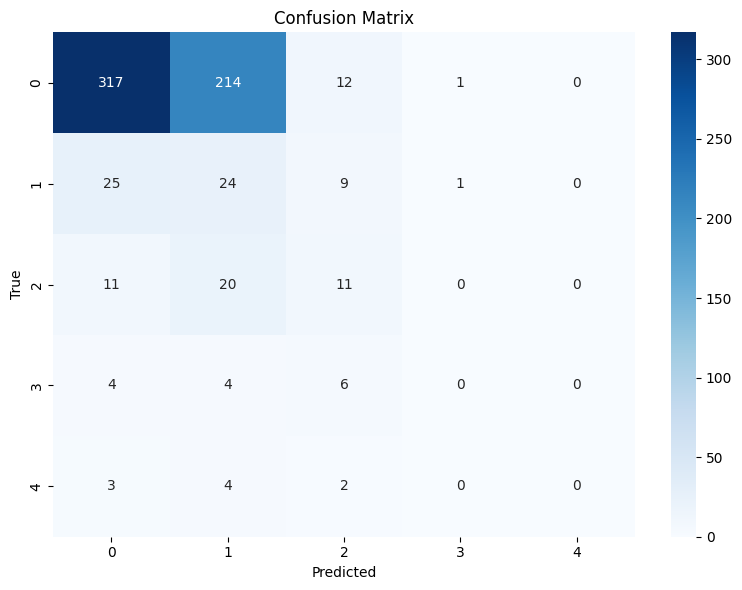


Test AUC (macro-average, OVR): 0.6368


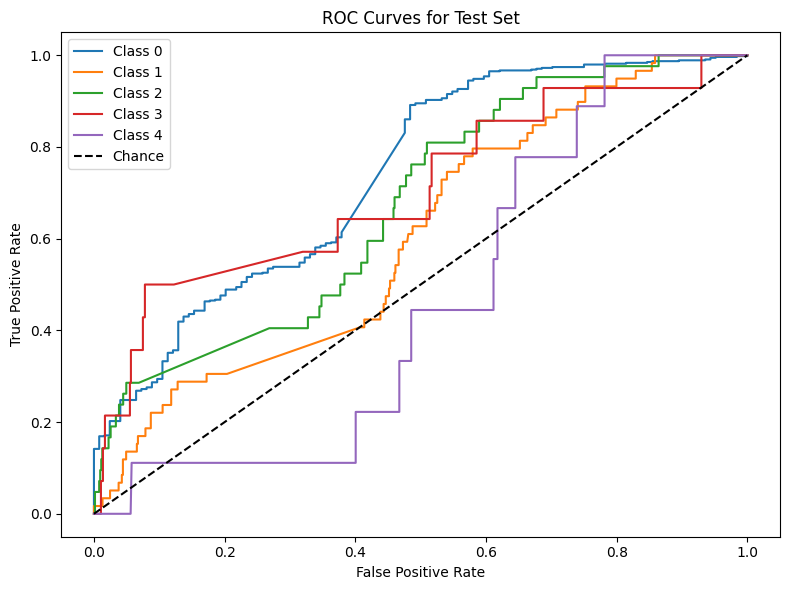

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       455
           1       0.14      0.25      0.18        52
           2       0.05      0.14      0.08        29
           3       0.25      0.40      0.31        10
           4       0.00      0.00      0.00         8

    accuracy                           0.63       554
   macro avg       0.27      0.30      0.27       554
weighted avg       0.76      0.63      0.68       554



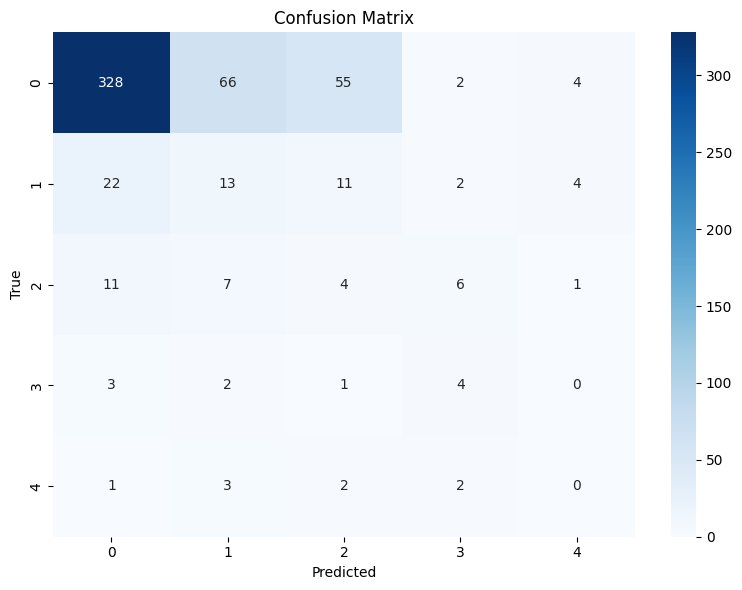


Test AUC (macro-average, OVR): 0.6242


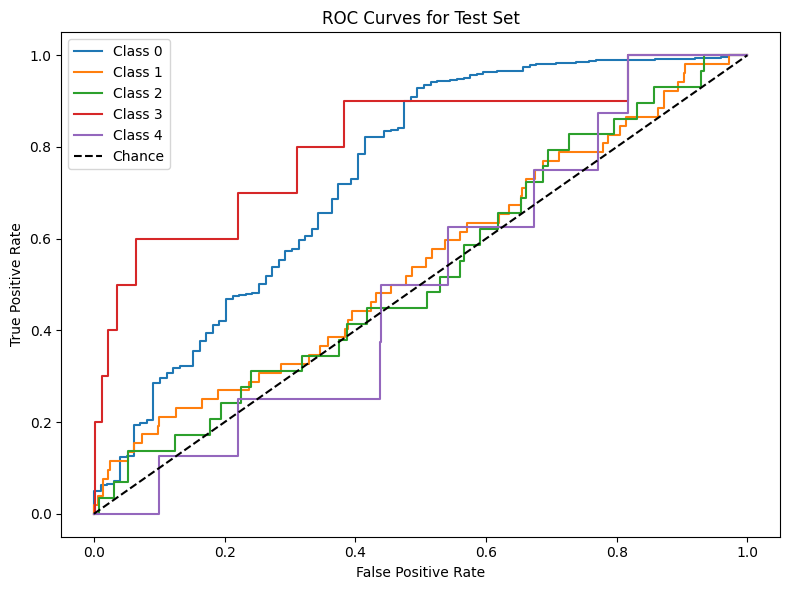

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.57      0.70       395
           1       0.11      0.33      0.17        40
           2       0.08      0.33      0.12        24
           3       0.00      0.00      0.00        10
           4       0.50      0.12      0.20         8

    accuracy                           0.52       477
   macro avg       0.32      0.27      0.24       477
weighted avg       0.77      0.52      0.60       477



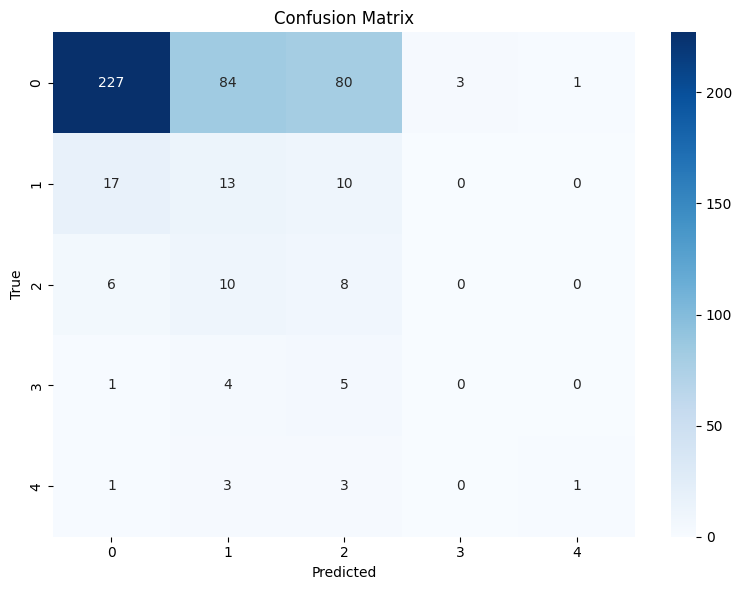


Test AUC (macro-average, OVR): 0.7157


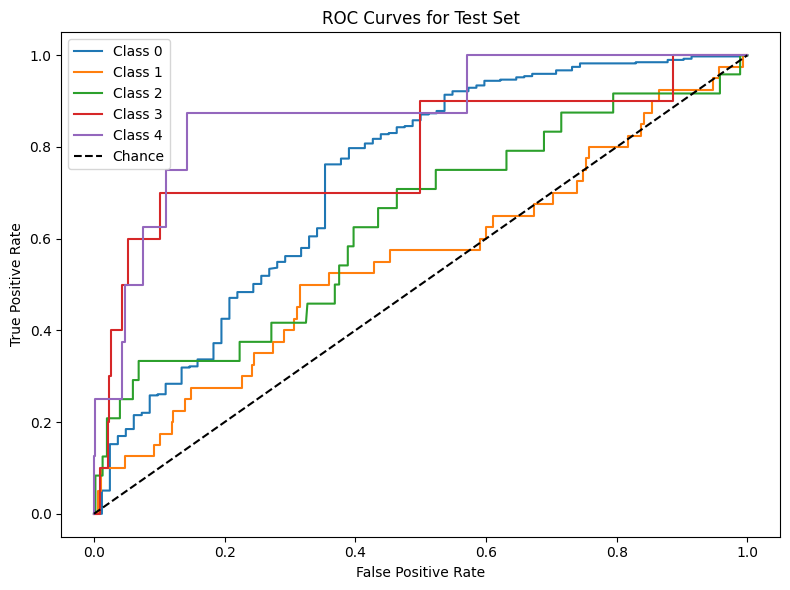

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
